In [1]:
# import libraries

import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import mygene
import sklearn.preprocessing as sk
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
import random
import warnings
from random import randint
from sklearn.model_selection import StratifiedKFold

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# define directories

cell_line_dir = "/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC/"
models_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/Models/GDSC_PDX_TCGA_Second_Strategy/"
finetuned_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/Models/GDSC_PDX_TCGA_Second_Strategy/Second_Strategy_Finetuned_Models/"
DEGs_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/DNA_REPi/"
dataset_dir = "/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/"
pathfindR_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/pathfindR/GDSC_PDX_TCGA_Second_Strategy/"
pdx_data_dir = "/Volumes/Expansion/Thesis Work/Datasets/PDX/Expression/"
fluorouracil_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/DNA_REPi/5-Fluorouracil/"
emc_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation_CNA/Predictions/GDSC_PDX_TCGA_Second_Strategy/"
ec_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_CNA/Predictions/GDSC_PDX_TCGA_Second_Strategy/"
save_results_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/Predictions/GDSC_PDX_TCGA_Second_Strategy/"
save_figures_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/Figures/GDSC_PDX_TCGA_Second_Strategy/"

In [3]:
# set random seeds

torch.manual_seed(42)
random.seed(42)

In [4]:
# change directory to read GDSC cell line details

os.chdir(cell_line_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC


In [5]:
# read GDSC cell line details table

GDSC_cell_line_details = pd.read_excel("GDSC_Cell_Lines_Details.xlsx", keep_default_na = False)
GDSC_cell_line_details.set_index("COSMIC identifier", inplace = True)
GDSC_cell_line_details = GDSC_cell_line_details.iloc[:-1,]
GDSC_cell_line_details.index = GDSC_cell_line_details.index.astype(str)
GDSC_cell_line_details.tail()

,Sample Name,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
COSMIC identifier,,,,,,,,,,,,
1299069,TMK-1,Y,Y,N,N,Y,digestive_system,stomach,STAD,,R,Adherent
1298218,KP-2,Y,N,Y,N,Y,pancreas,pancreas,PAAD,,D/F12,Adherent
1330932,KO52,Y,Y,N,N,N,leukemia,acute_myeloid_leukaemia,LAML,MSS/MSI-L,D/F12,NA
1331030,SC-1,Y,Y,N,N,N,lymphoma,B_cell_lymphoma,DLBC,MSS/MSI-L,R,NA
1503373,U-CH2,Y,Y,N,N,N,bone,bone_other,,MSS/MSI-L,D/F12,Adherent


In [6]:
# change directory to read GDSC expression dataset (DNA_REPi)

os.chdir(dataset_dir + "/exprs/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs


In [7]:
# read GDSC expression dataset (DNA_REPi)

GDSCE = pd.read_csv("GDSC_exprs.z.DNA_REPi.tsv", 
                    sep = "\t", index_col=0, decimal = ",")
GDSCE = pd.DataFrame.transpose(GDSCE)
GDSCE.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,107984199,107984208,107984325,107984411,107984648,107984889,107984989,107986313,107986782,107986810
683665,-0.4711563767951986,-0.1857522957766964,0.9702409548662462,-0.4081281805960821,-0.4161511169999803,-0.4384159723467665,-1.154692246005183,0.5262132484107975,-0.7950924576033422,-0.6337442716864214,...,1.283534690590172,-0.3367265464586691,-0.0039762988723447,0.7378729872604209,0.9757614264575688,0.1494417647095801,2.062294063911948,-0.8140636761719959,0.2870333828833719,0.9524265085537148
684055,1.3565140948247052,-0.277542411913307,0.0887087882196536,-0.2754829982302413,-0.5153856346587746,-0.6248712076433911,0.1243408990866293,-1.2699667684674136,2.0788360886382717,2.5197991997459197,...,-0.5571028630154293,-1.724090733574364,-0.3749080365068901,-0.0016055431935905,-0.3788535663547365,-1.3502092798315848,0.6949790577550328,0.4333032198982747,-0.1280986270308099,-1.629249958712223
684057,0.6510004960254864,1.6578876382433665,-0.4977106390881842,-0.1212172092933644,-0.398455281697677,-0.2804901106672752,0.6455898116420014,0.215833091774836,-0.1723595788875009,-0.2170870770552223,...,-0.024863133395904,0.4073439017665206,-0.4440356638831038,0.8630347078663075,1.4486171428489227,-1.4777214830771732,0.5220400480464272,0.6441211958947753,0.9057518606131394,0.3018783753479829


In [8]:
# change directory to read GDSC mutation dataset (DNA_REPi)

os.chdir(dataset_dir + "/mutations/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations


In [9]:
# read GDSC mutation dataset (DNA_REPi)

GDSCM = pd.read_csv("GDSC_mutations.DNA_REPi.tsv",
                    sep="\t", index_col=0, decimal=".")
GDSCM.drop_duplicates(keep='last')
GDSCM = pd.DataFrame.transpose(GDSCM)
GDSCM = GDSCM.loc[:, ~GDSCM.columns.duplicated()]

GDSCM.head()

,143872,728577,2,2050,10243,79365,256006,4609,118788,113675,...,26517,28972,53917,283507,514,339210,64981,7335,5739,83442
683665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# change directory to read GDSC response dataset (DNA_REPi)

os.chdir(dataset_dir + "/response/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response


In [11]:
# read GDSC response dataset (DNA_REPi)

GDSCR = pd.read_csv("GDSC_response.DNA_REPi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCR.dropna(inplace=True)
GDSCR.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
GDSCR["response"] = GDSCR.loc[:, "response"].apply(lambda x: d[x])
GDSCR = GDSCR.loc[GDSCR["drug"] != "5-fluorouracil", ]

GDSCR.head()

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,0,5.12075503641523,Pyrimethamine,1,1,1
683665,0,-3.03711635474651,Doxorubicin,1,1,1
683665,0,-0.712119156515401,Etoposide,1,1,1
683665,0,-4.40897202584936,Gemcitabine,1,1,1
683665,0,-1.59752443691324,Mitomycin C,1,1,1


In [12]:
# print count of cell lines for each drug (DNA_REPi)

GDSCR["drug"].value_counts()

drug
Etoposide         775
SN-38             771
Mitomycin C       767
Doxorubicin       766
5-Fluorouracil    764
Gemcitabine       761
Bleomycin         759
Temozolomide      752
Cisplatin         738
Methotrexate      738
Camptothecin      737
Cytarabine        735
Pyrimethamine     372
Name: count, dtype: int64

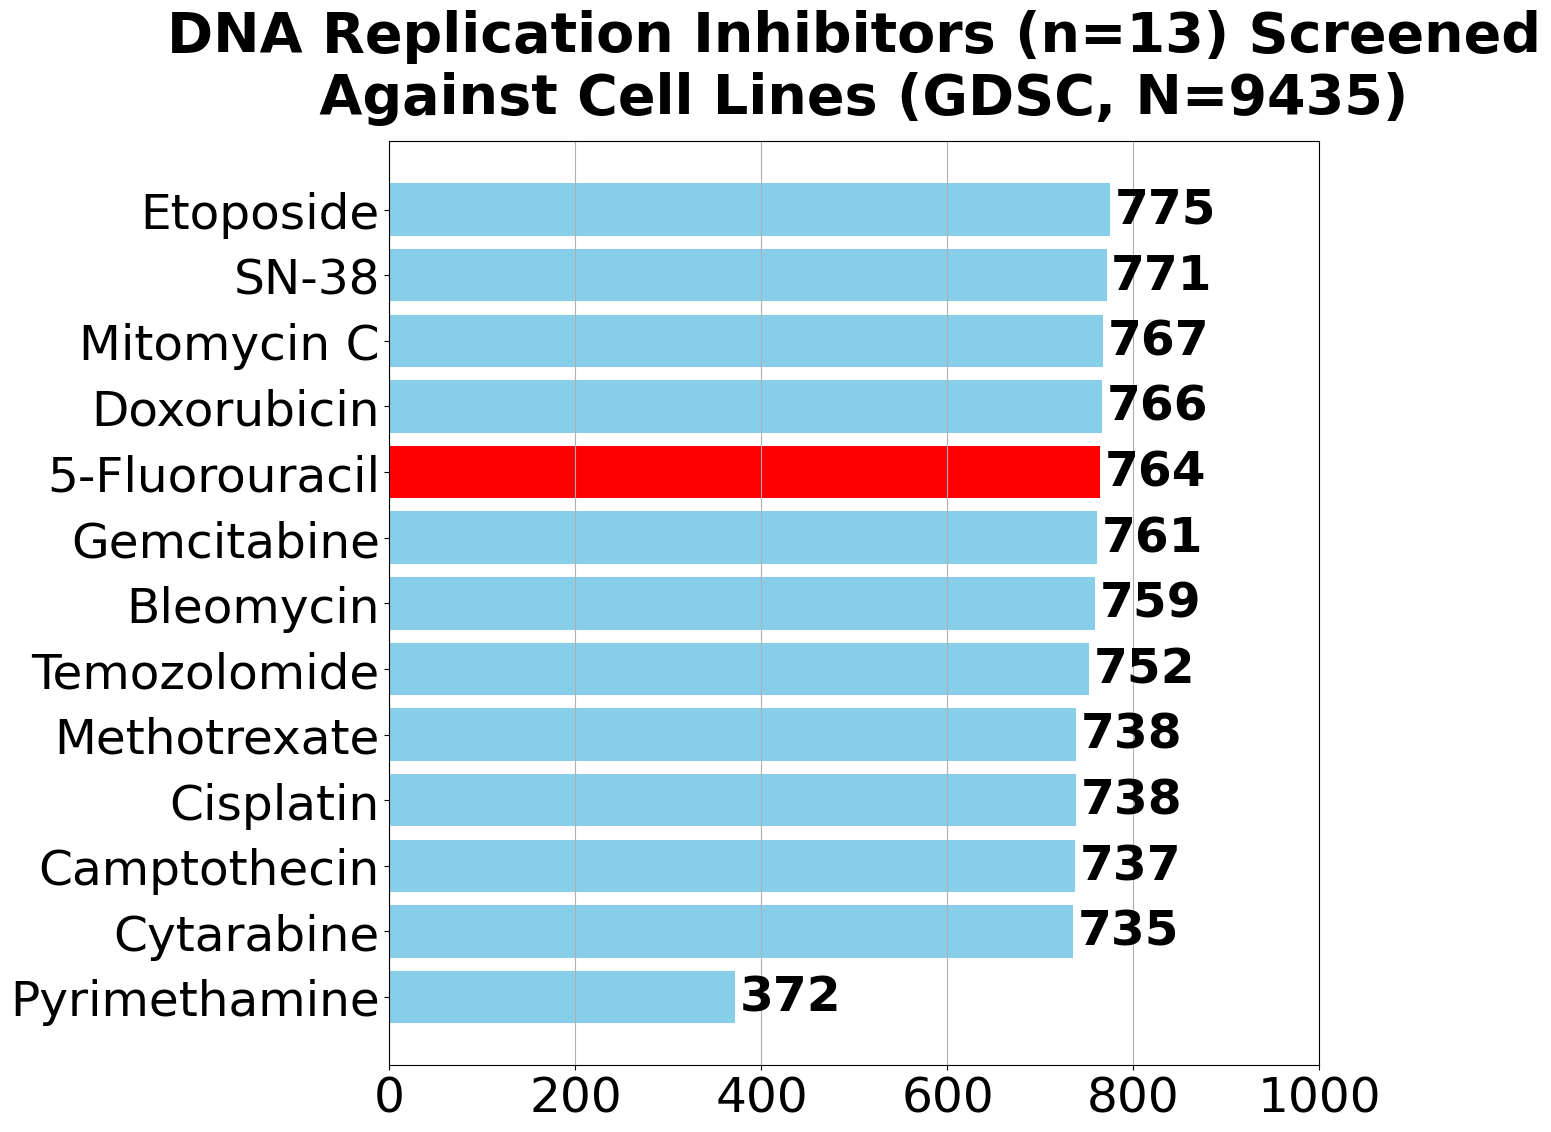

In [13]:
# PLOT DNA Replication İnhibitors with their counts

gdsc_drugs = dict(GDSCR["drug"].value_counts())
gdsc_drugs = dict(sorted(gdsc_drugs.items(), key=lambda item: item[1], reverse=False))
drug_names = list(gdsc_drugs.keys())
drug_values = list(gdsc_drugs.values())

import os
import matplotlib.pyplot as plt

# Create the figure
plt.figure(figsize=(12, 12))
bars = plt.barh(drug_names, drug_values, color='skyblue')

# Add text annotations
for bar, value in zip(bars, drug_values):
    plt.text(value + 5, bar.get_y() + bar.get_height() / 2, str(value), va='center', fontsize=35, fontweight="bold")

# Update bar colors for specific drug names
bars = []
for name, value in zip(drug_names, drug_values):
    if name == "5-Fluorouracil":
        bars.append(plt.barh(name, value, color='red'))
    elif name == "5-Fluorouracil":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))

# Add labels, title, and grid
plt.xlabel(None)
plt.title(f'DNA Replication Inhibitors (n={len(drug_names)}) Screened\n Against Cell Lines (GDSC, N=9435)',
          fontweight='bold',
          fontsize=40,
          pad=20)
plt.xlim(0, 1000)
plt.grid(axis='x')
plt.tick_params(axis='y', labelsize=35)
plt.tick_params(axis='x', labelsize=35)

# Capture the figure object
fig_B = plt.gcf()  # Assign current figure to fig_B

# Save the figure
os.makedirs(save_figures_to, exist_ok = True)
fig_B.savefig(save_figures_to + 'DNA Replication Inhibitors with Their Counts (GDSC, 5-Fluorouracil).png',
              format='png', bbox_inches='tight')

# Show the plot
plt.show()

In [14]:
# change directory to read PDX and TCGA expression datasets homogenized with GDSC expression dataset (5-Fluorouracil)

os.chdir(dataset_dir + "/exprs_homogenized/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs_homogenized


In [15]:
# read PDX expression dataset homogenized with GDSC expression dataset (5-Fluorouracil)

PDXEfluorouracil = pd.read_csv("PDX_exprs.5-Fluorouracil.eb_with.GDSC_exprs.5-Fluorouracil.tsv",
                   sep = "\t", index_col=0, decimal = ",")
PDXEfluorouracil = pd.DataFrame.transpose(PDXEfluorouracil)
PDXEfluorouracil.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100507206,100507254,100507436,100507472,100526773,100527978,100532746,100820829,102724473,105375355
X-1027,4.11649564280422,3.59209496158439,6.28559101273304,2.67926549063284,3.04621480878604,2.69044790660834,8.01420464403606,2.73140674359613,8.71768731731273,2.89488898093329,...,2.71033163066003,3.2543218456306,5.67560198356418,3.07143466694584,3.0597754133993,2.63635721806084,2.61292331163008,3.18623983789074,0,2.4522722382887
X-1119,4.00318976265845,3.59209496158439,7.55375516379688,4.03669966422185,3.41557516120483,5.94712898968845,8.14610109582064,2.54373640699005,7.8874359290969,3.43325748497387,...,2.80929358976047,3.3020335598854,8.94930072777643,3.07143466694584,3.0597754133993,2.63635721806084,2.61292331163008,4.60199637750889,0,2.89512503666773
X-1173,3.74198340066366,3.67493736139833,6.16750446793135,3.50545765081401,3.04295501121306,2.98779164904873,8.37697489020915,2.64942372799293,8.2967442081863,4.13640544224621,...,2.71033163066003,3.2543218456306,4.67270724878415,3.07143466694584,3.0597754133993,2.63635721806084,2.61292331163008,4.99706823903714,0,3.34491841640924


In [16]:
# read TCGA expression dataset homogenized with GDSC expression dataset (5-Fluorouracil)

TCGAEfluorouracil = pd.read_csv("TCGA_exprs.Fluorouracil.eb_with.GDSC_exprs.5-Fluorouracil.tsv",
                   sep = "\t", index_col=0, decimal = ",")
TCGAEfluorouracil = pd.DataFrame.transpose(TCGAEfluorouracil)
TCGAEfluorouracil.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100188893,100190940,100190949,100191040,100192386,100268168,100271715,100287718,100288778,100289635
TCGA-3A-A9IC,5.72964960061116,4.41876362025309,4.86023990366878,2.47277876318537,4.81396331677419,2.6727941627861,8.72268461889477,2.5342747028707,8.30356599972612,2.66680810277045,...,9.61327758421809,2.69169602849574,2.74156299885291,3.14358416474115,3.63806017988108,2.83936659460498,2.84468471240513,2.9097524321588,4.74904572228446,4.63830114019886
TCGA-3A-A9IX,5.16820185705619,5.0656506669595,5.05015666335564,2.49748103264488,6.24486748738657,3.89184369807008,8.07246325142995,2.65471072107481,8.69196063245573,3.97461007293206,...,9.28039145658571,2.68523221938676,2.70770230320119,3.1831168236566,3.17601340812919,2.66266337139924,3.05740520413346,2.9097524321588,4.66674620630048,4.95684240309785
TCGA-AG-3593,4.09489404413517,3.56187701617794,5.74195136365074,3.52505514866919,0.688407410705727,2.04131612004455,8.50563761093224,2.83121226059543,8.98277420895832,4.7862922506412,...,9.44820752386781,3.3077275660044,3.04450667890368,3.53272687811095,2.90679846697165,2.45941479590968,2.65824917267036,2.9097524321588,5.80963066021836,4.86261821976041


In [17]:
# change directory to read PDX mutation dataset (5-Fluorouracil)

os.chdir(dataset_dir + "mutations")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations'

In [18]:
# read PDX mutation dataset (5-Fluorouracil)

PDXMfluorouracil = pd.read_csv("PDX_mutations.5-Fluorouracil.tsv",
                        sep="\t", index_col=0, decimal=",")
PDXMfluorouracil.drop_duplicates(keep='last')
PDXMfluorouracil = pd.DataFrame.transpose(PDXMfluorouracil)
PDXMfluorouracil = PDXMfluorouracil.loc[:, ~PDXMfluorouracil.columns.duplicated()]

PDXMfluorouracil.head(3)

ENTREZID,3075.0,171017.0,2058.0,79890.0,7701.0,3104.0,4642.0,9778.0,100132406.0,23607.0,...,253738.0,154807.0,79140.0,6307.0,6352.0,56005.0,115650.0,64946.0,5777.0,253639.0
X-1027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1119,0.0,-0.05,0.0,-0.05,0.0,0.0,0.0,0.0,-0.05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1173,0.0,0.0,0.0,-0.05,0.0,0.0,0.0,0.0,-0.05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# read TCGA mutation dataset (5-Fluorouracil)

TCGAMfluorouracil = pd.read_csv("TCGA_mutations.Fluorouracil.tsv",
                        sep="\t", index_col=0, decimal=",")
TCGAMfluorouracil.drop_duplicates(keep='last')
TCGAMfluorouracil = pd.DataFrame.transpose(TCGAMfluorouracil)
TCGAMfluorouracil = TCGAMfluorouracil.loc[:, ~TCGAMfluorouracil.columns.duplicated()]

TCGAMfluorouracil.head(3)

,9729,2050,515,140803,55814,51207,27143,152586,283659,51725,...,170393,401940,3249,254958,388199,55049,162699,114299,55969,147841
TCGA-3A-A9IC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-3A-A9IX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-AG-3593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# variance threshold for GDSC expression dataset (DNA_REPi)

selector = VarianceThreshold(0.05)
selector.fit_transform(GDSCE)
GDSCE = GDSCE[GDSCE.columns[selector.get_support(indices=True)]]

In [21]:
# fill NA values and binarize GDSC mutation dataset (DNA_REPi)

GDSCM = GDSCM.fillna(0)
GDSCM[GDSCM != 0.0] = 1

In [22]:
# select shared genes between GDSC, PDX, and TCGA expression and mutation datasets 

ls = GDSCE.columns.intersection(GDSCM.columns)
ls = ls.intersection(PDXEfluorouracil.columns)
ls = ls.intersection(PDXMfluorouracil.columns)
ls = ls.intersection(TCGAEfluorouracil.columns)
ls = ls.intersection(TCGAMfluorouracil.columns)

ls = pd.unique(ls)

print(f"GDSC, PDX & TCGA # of common genes: {ls.shape[0]}")

GDSC, PDX & TCGA # of common genes: 13700


In [23]:
# select shared samples between GDSC expression, mutation, and response datasets (DNA_REPi)

ls2 = GDSCE.index.intersection(GDSCM.index)
ls2 = ls2.intersection(GDSCR.index)

print(f"GDSC # of common cell lines: {ls2.shape[0]}")

GDSC # of common cell lines: 801


In [24]:
# subset shared genes and samples in GDSC expression, mutation, and response datasets

GDSCE = GDSCE.loc[ls2, ls]
GDSCM = GDSCM.loc[ls2, ls]
GDSCR = GDSCR.loc[ls2, :]

print(f"GDSC # of common samples and genes (Expression): {GDSCE.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCM.shape}")
print(f"GDSC # of samples (Response): {GDSCR.shape[0]}")

GDSC # of common samples and genes (Expression): (801, 13700)
GDSC # of common samples and genes (Mutation): (801, 13700)
GDSC # of samples (Response): 9435


In [25]:
# select shared samples between PDX expression and mutation datasets (5-Fluorouracil) 

ls3 = PDXEfluorouracil.index.intersection(PDXMfluorouracil.index)

print(f"PDX # of common samples (5-Fluorouracil): {ls3.shape[0]}")

PDX # of common samples (5-Fluorouracil): 23


In [26]:
# select shared samples between TCGA expression and mutation datasets (5-Fluorouracil) 

ls4 = TCGAEfluorouracil.index.intersection(TCGAMfluorouracil.index)

print(f"TCGA # of common samples (5-Fluorouracil): {ls4.shape[0]}")

TCGA # of common samples (5-Fluorouracil): 33


In [27]:
# select shared genes and samples between PDX and TCGA expression and mutation datasets (5-Fluorouracil)

PDXEfluorouracil = PDXEfluorouracil.loc[ls3, ls]
PDXMfluorouracil = PDXMfluorouracil.loc[ls3, ls]

TCGAEfluorouracil = TCGAEfluorouracil.loc[ls4, ls]
TCGAMfluorouracil = TCGAMfluorouracil.loc[ls4, ls]

print(f"PDX # of common samples and genes for Expression (5-Fluorouracil): {PDXEfluorouracil.shape}")
print(f"PDX # of common samples and genes for Mutation (5-Fluorouracil): {PDXMfluorouracil.shape}\n")

print(f"TCGA # of common samples and genes for Expression (5-Fluorouracil): {TCGAEfluorouracil.shape}")
print(f"TCGA # of common samples and genes for Mutation (5-Fluorouracil): {TCGAMfluorouracil.shape}")

PDX # of common samples and genes for Expression (5-Fluorouracil): (23, 13700)
PDX # of common samples and genes for Mutation (5-Fluorouracil): (23, 13700)

TCGA # of common samples and genes for Expression (5-Fluorouracil): (33, 13700)
TCGA # of common samples and genes for Mutation (5-Fluorouracil): (33, 13700)


In [28]:
# change directory

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/DNA_REPi


In [29]:
# read DNA_REPi_Differentially_Expressed_Genes common among DNA replication inhibitors

DEGs_filtered_data = pd.read_excel("DNA_REPi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                    sheet_name = "Common DEGs")
print(f"There are {DEGs_filtered_data.shape[0]} DEGs (p-adjusted < 0.05 and |logFC| > 1) among DNA replication inhibitors\n")

DEGs_filtered_data.head()

There are 858 DEGs (p-adjusted < 0.05 and |logFC| > 1) among DNA replication inhibitors



,Gene Symbol,Frequency
0,SLFN11,9
1,NCKAP1L,8
2,SDC4,7
3,KRT18,7
4,S100A14,7


In [30]:
filter = DEGs_filtered_data["Frequency"] == 1
DEGs_freq_one =  DEGs_filtered_data[filter]
DEGs_freq_one.head()

,Gene Symbol,Frequency
545,ELF1,1
546,PROSER2,1
547,CLIP4,1
548,THAP10,1
549,SHTN1,1


In [31]:
DEGs_fluorouracil_data = pd.read_excel("DNA_REPi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                              sheet_name = "5-Fluorouracil")

filter = DEGs_fluorouracil_data["Gene.Symbol"].isin(DEGs_freq_one["Gene Symbol"])
only_fluorouracil_degs = DEGs_fluorouracil_data.loc[filter, "Gene.Symbol"]

print(f'There are {only_fluorouracil_degs.shape[0]} DEGs unique to 5-FU, so they were removed from the DEGs list')

There are 24 DEGs unique to 5-FU, so they were removed from the DEGs list


In [32]:
filter = DEGs_filtered_data["Gene Symbol"].isin(only_fluorouracil_degs)
DEGs_filtered_data = DEGs_filtered_data[~filter]

DEGs_filtered_data.head()

,Gene Symbol,Frequency
0,SLFN11,9
1,NCKAP1L,8
2,SDC4,7
3,KRT18,7
4,S100A14,7


In [33]:
# get gene symbol from mygene database

mg = mygene.MyGeneInfo()
DEGs_entrez_id = mg.querymany(DEGs_filtered_data["Gene Symbol"], 
                              species="human", 
                              scopes = "symbol",
                              field = "entrezgene",
                              as_dataframe=True)["entrezgene"]
DEGs_entrez_id.dropna(inplace=True)

DEGs_entrez_id.shape[0]

1 input query terms found dup hits:	[('CLECL1P', 2)]


834

In [34]:
# assign GDSC datasets to new variables

exprs_z = GDSCE
mut = GDSCM
responses = GDSCR

In [35]:
# GDSC response dataset

responses.head(3)

,response,logIC50,drug,exprs,CNA,mutations
683665,0,5.12075503641523,Pyrimethamine,1,1,1
683665,0,-3.03711635474651,Doxorubicin,1,1,1
683665,0,-0.712119156515401,Etoposide,1,1,1


In [36]:
# list drug names in GDSC response dataset

drugs = set(responses["drug"].values)
drugs

{'5-Fluorouracil',
 'Bleomycin',
 'Camptothecin',
 'Cisplatin',
 'Cytarabine',
 'Doxorubicin',
 'Etoposide',
 'Gemcitabine',
 'Methotrexate',
 'Mitomycin C',
 'Pyrimethamine',
 'SN-38',
 'Temozolomide'}

In [37]:
# convert Entrez gene IDs to integer

GDSCE.index = GDSCE.index.astype(str)
GDSCM.index = GDSCM.index.astype(str)
responses.index = responses.index.astype(str)

In [38]:
# merge GDSC cell line details with response dataset

dat = pd.merge(GDSC_cell_line_details,
         responses,
         left_index = True, 
         right_index=True,
         how = "inner")

dat["GDSC\nTissue descriptor 1"].value_counts()
#dat.head()

GDSC\nTissue descriptor 1
lung_NSCLC           1037
urogenital_system     926
leukemia              829
lymphoma              769
aero_dig_tract        727
nervous_system        607
lung_SCLC             569
skin                  560
breast                524
digestive_system      466
large_intestine       447
bone                  421
neuroblastoma         332
pancreas              294
kidney                227
soft_tissue           191
myeloma               182
lung                  174
thyroid               153
Name: count, dtype: int64

In [39]:
# get tissue descriptors

dat["GDSC\nTissue\ndescriptor 2"].value_counts().head()

GDSC\nTissue\ndescriptor 2
lung_NSCLC_adenocarcinoma    639
lung_small_cell_carcinoma    569
glioma                       558
breast                       524
melanoma                     522
Name: count, dtype: int64

In [40]:
# assign tissue descriptors to variable

gdsc_tissue_counts = dat["GDSC\nTissue descriptor 1"].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_names

['lung_NSCLC',
 'urogenital_system',
 'leukemia',
 'lymphoma',
 'aero_dig_tract',
 'nervous_system',
 'lung_SCLC',
 'skin',
 'breast',
 'digestive_system',
 'large_intestine',
 'bone',
 'neuroblastoma',
 'pancreas',
 'kidney',
 'soft_tissue',
 'myeloma',
 'lung',
 'thyroid']

In [41]:
# list count of cell lines as to tissues treated with fluorouracil

filter = (dat["drug"] == "5-Fluorouracil")
dat.loc[filter,"GDSC\nTissue descriptor 1"].value_counts()

GDSC\nTissue descriptor 1
lung_NSCLC           86
urogenital_system    78
leukemia             63
aero_dig_tract       59
lymphoma             57
nervous_system       50
skin                 47
lung_SCLC            46
breast               44
large_intestine      38
digestive_system     37
bone                 34
neuroblastoma        28
pancreas             25
kidney               18
lung                 15
soft_tissue          14
myeloma              13
thyroid              12
Name: count, dtype: int64

In [42]:
# list count of cell lines as to tissues treated with fluorouracil

tissues_drugs = dat[["GDSC\nTissue descriptor 1","GDSC\nTissue\ndescriptor 2","drug"]]

filter = (tissues_drugs["drug"] == "5-Fluorouracil")
tissues_drug = tissues_drugs.loc[filter,"GDSC\nTissue\ndescriptor 2"].value_counts()

tissues_drug.head()

GDSC\nTissue\ndescriptor 2
lung_NSCLC_adenocarcinoma    53
glioma                       46
lung_small_cell_carcinoma    46
breast                       44
melanoma                     44
Name: count, dtype: int64

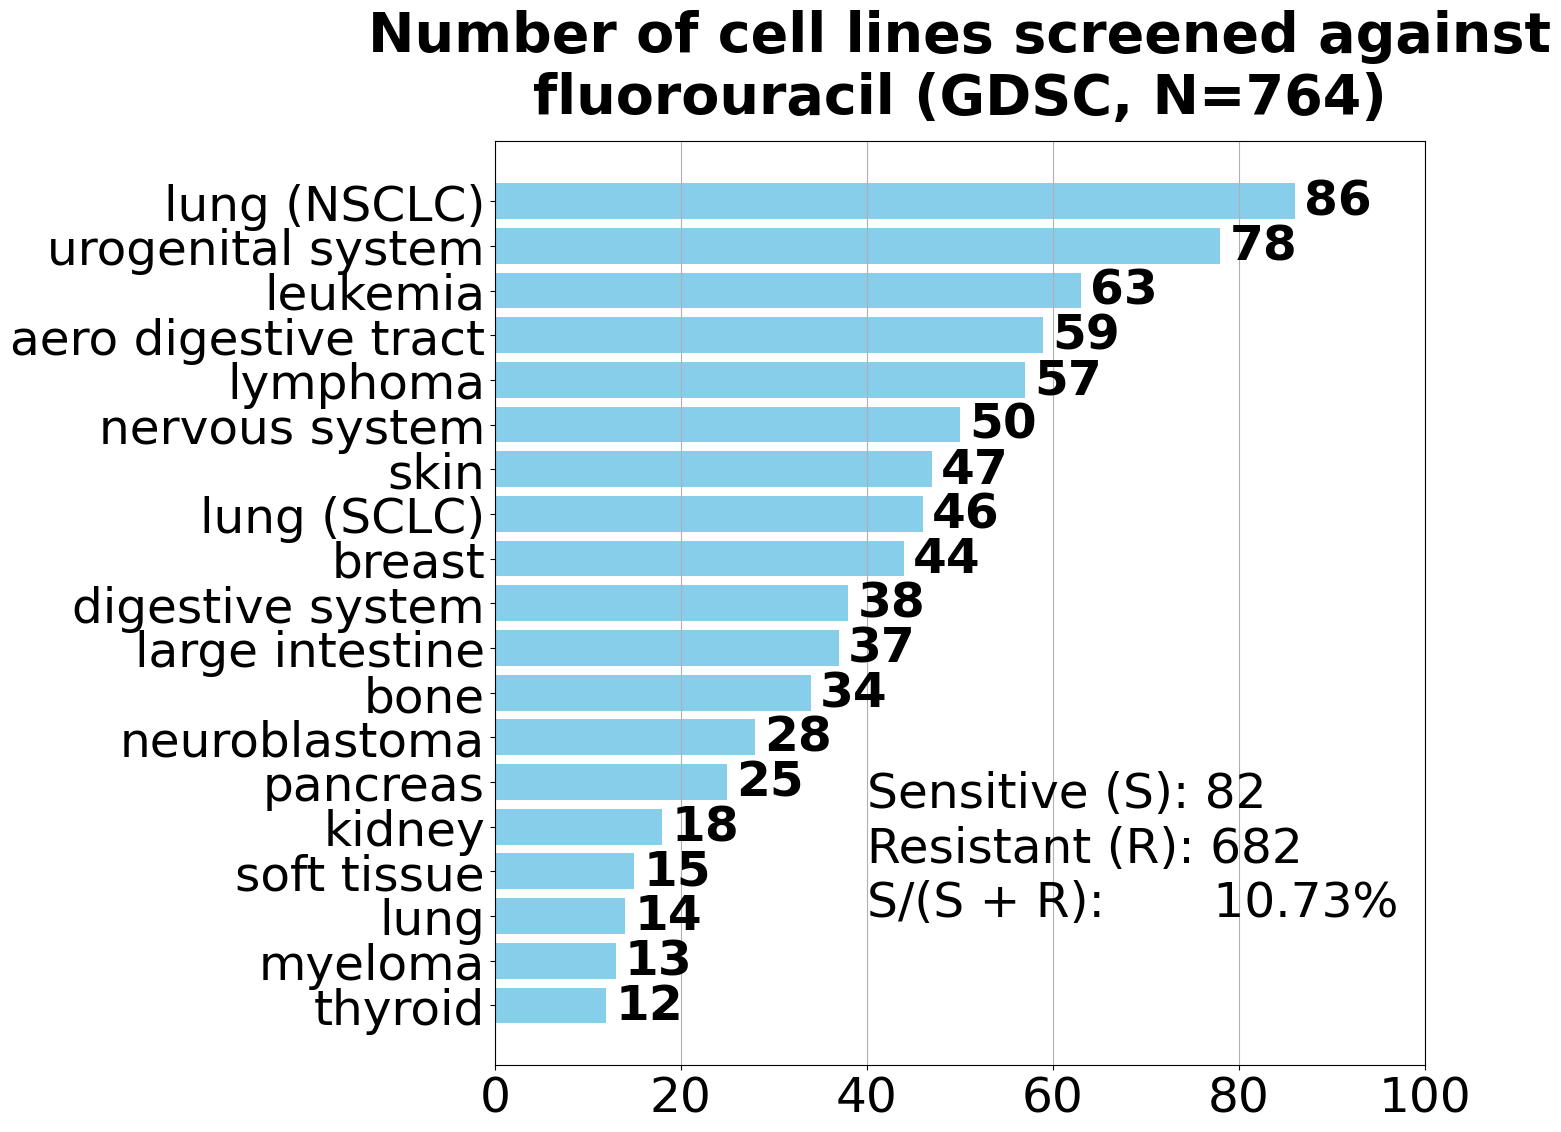

In [43]:
# plot tissue types of cancer cell lines treated with DNA replication inhibitors

gdsc_tissue_counts =  tissues_drugs.loc[filter, 'GDSC\nTissue descriptor 1'].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_names = ["lung (NSCLC)", "urogenital system", "leukemia", "aero digestive tract", "lymphoma", 
                    "nervous system", "skin", "lung (SCLC)", "breast",  "digestive system","large intestine",
                    "bone", "neuroblastoma", "pancreas",
                    "kidney",  "soft tissue", "lung", "myeloma", "thyroid"]
tissue_counts = list(gdsc_tissue_counts)


# Ensure the save path exists
os.makedirs(save_figures_to, exist_ok=True)

# Create the figure
plt.figure(figsize=(12, 12))
plt.barh(tissue_names, tissue_counts, color='skyblue')
plt.xlabel(None)
plt.title(f'Number of cell lines screened against\nfluorouracil (GDSC, N={sum(tissue_counts)})',
          fontweight='bold',
          fontsize=40,
          pad=20)
plt.gca().invert_yaxis()
plt.xlim(0, 100)
plt.grid(axis='x')
plt.tick_params(axis='y', labelsize=35)
plt.tick_params(axis='x', labelsize=35)

# Add bars and annotations
bars = plt.barh(tissue_names, tissue_counts, color='skyblue')
for bar, value in zip(bars, tissue_counts):
    plt.text(value + 1, bar.get_y() + bar.get_height() / 2, str(value), va='center', fontsize=35, fontweight="bold")

# Add summary text
plt.text(40, 16,
         f'Sensitive (S): {dat.loc[dat["drug"] == "5-Fluorouracil", "response"].value_counts()[1]} \n'
         f'Resistant (R): {dat.loc[dat["drug"] == "5-Fluorouracil", "response"].value_counts()[0]} \n'
         f'S/(S + R):       {round(dat.loc[dat["drug"] == "5-Fluorouracil", "response"].value_counts()[1] / (sum(dat.loc[dat["drug"] == "5-Fluorouracil", "response"].value_counts())) * 100, 2)}%',
         fontsize=35,
         color='black')

# Capture the figure object
fig_D = plt.gcf()  # Assign current figure to fig_D

# Save the figure
fig_D.savefig(save_figures_to + 'Tissue_types_of_cancer_cell_lines_treated_with_Fluorouracil.png',
              format='png', bbox_inches='tight')

# Show the plot
plt.show()

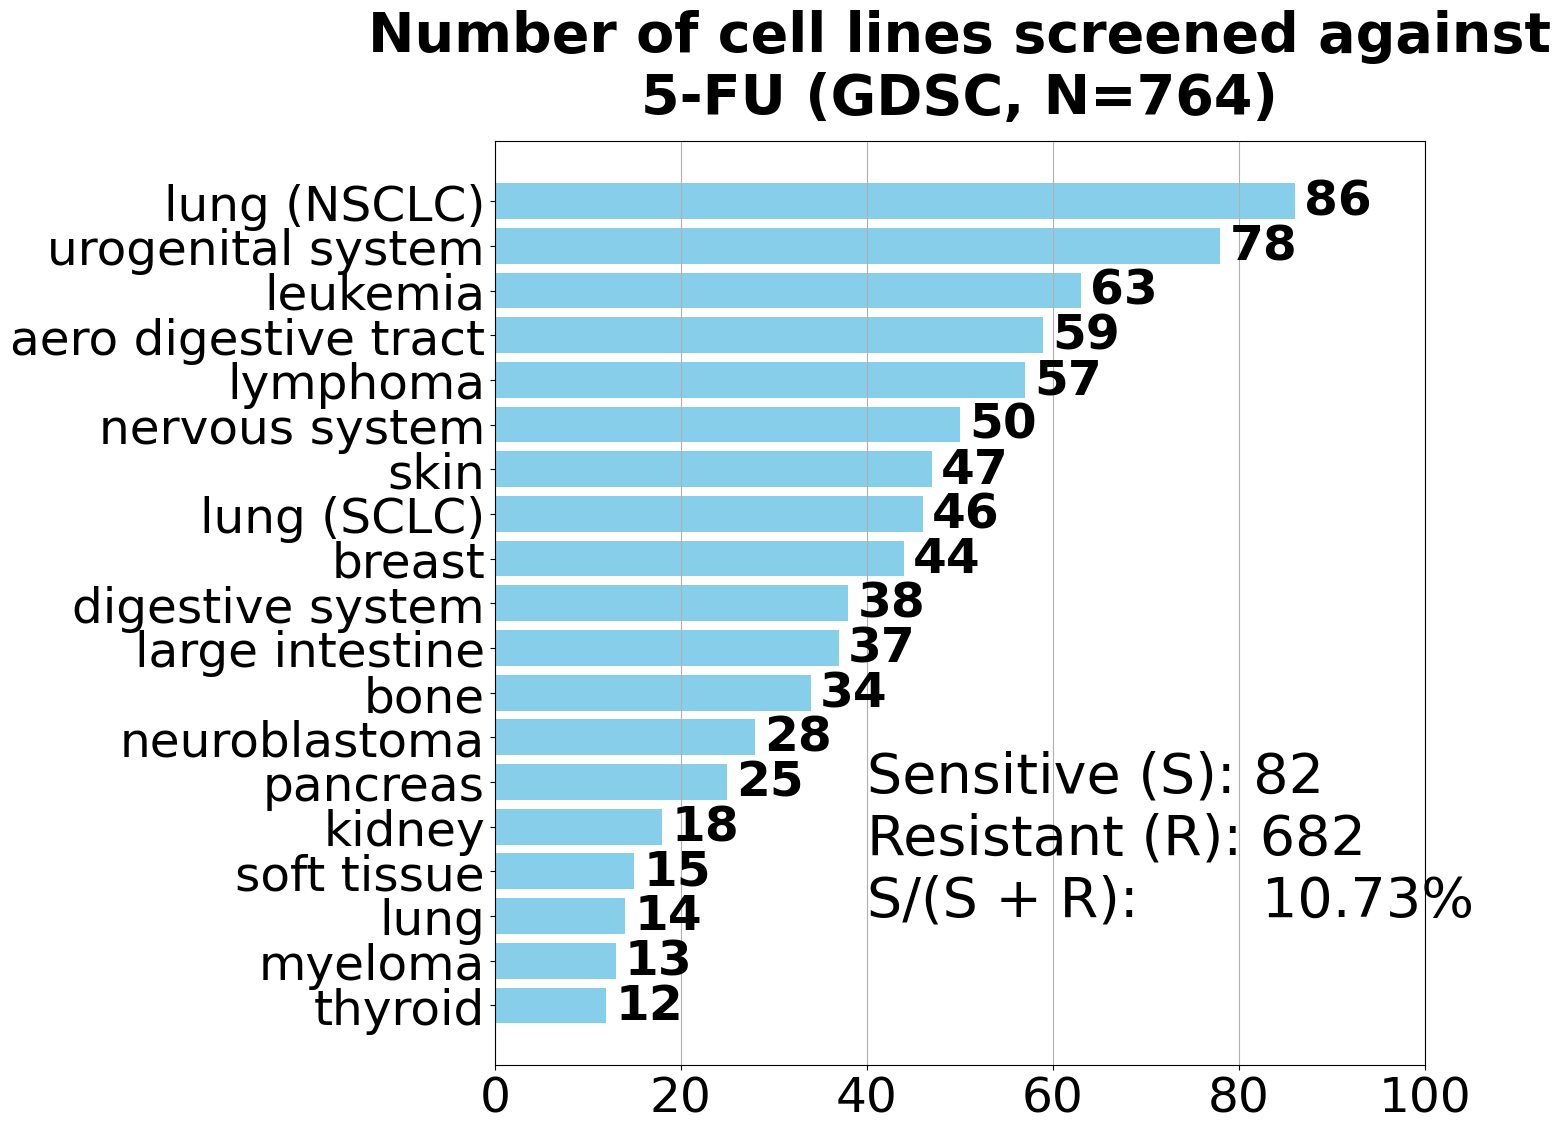

In [44]:
# plot tissue types of cancer cell lines treated with 5-FU

plt.figure(figsize=(12, 12))
plt.barh(tissue_names, tissue_counts, color='skyblue')
plt.xlabel(None)
plt.title(f'Number of cell lines screened against\n5-FU (GDSC, N={sum(tissue_counts)})',
          fontweight='bold',
          fontsize=40,
          pad=20)
plt.gca().invert_yaxis()
plt.xlim(0, 100)
plt.grid(axis='x')
plt.tick_params(axis='y', labelsize=35)
plt.tick_params(axis='x', labelsize=35)

# Add bars and annotations
bars = plt.barh(tissue_names, tissue_counts, color='skyblue')
for bar, value in zip(bars, tissue_counts):
    plt.text(value + 1, bar.get_y() + bar.get_height() / 2, str(value), va='center', fontsize=35, fontweight="bold")

# Add summary text
plt.text(40, 16,
         f'Sensitive (S): {dat.loc[dat["drug"] == "5-Fluorouracil", "response"].value_counts()[1]} \n'
         f'Resistant (R): {dat.loc[dat["drug"] == "5-Fluorouracil", "response"].value_counts()[0]} \n'
         f'S/(S + R):       {round(dat.loc[dat["drug"] == "5-Fluorouracil", "response"].value_counts()[1] / (sum(dat.loc[dat["drug"] == "5-Fluorouracil", "response"].value_counts())) * 100, 2)}%',
         fontsize=40,
         color='black')

# Capture the figure object
fig_C = plt.gcf()  # Assign current figure to fig_C

# Save the figure
fig_C.savefig(save_figures_to + 'Tissue_types_of_cancer_cell_lines_treated_with_5_Fluorouracil.png',
              format='png', bbox_inches='tight')

# Show the plot
plt.show()

In [45]:
# convert Entrez gene IDs to string

responses.index = responses.index.astype(str)
responses.index

Index(['683665', '683665', '683665', '683665', '683665', '683665', '683665',
       '683665', '683665', '683665',
       ...
       '1659818', '1659818', '1659818', '1659818', '1659819', '1659819',
       '1659819', '1659819', '1659819', '687800'],
      dtype='object', length=9435)

In [46]:
# filter GDSC expression and mutation datasets (DNA_REPi) as to drugs
# subset selected DEGs

expression_zscores = []
mutations = []
for drug in drugs:
    samples = responses.loc[responses["drug"] == drug, :].index.values
    e_z = exprs_z.loc[samples, :]
    m = mut.loc[samples, :]
    expression_zscores.append(e_z)
    mutations.append(m)

GDSCEv2 = pd.concat(expression_zscores, axis=0)
GDSCMv2 = pd.concat(mutations, axis=0)
GDSCRv2 = responses

ls5 = list(set(GDSCE.columns).intersection(set(DEGs_entrez_id.astype(int))))
ls6 = GDSCEv2.index.intersection(GDSCMv2.index)

GDSCEv2 = GDSCEv2.loc[ls6, ls5]
GDSCMv2 = GDSCMv2.loc[ls6, ls5]
GDSCRv2 = GDSCRv2.loc[ls6, :]

PDXEfluorouracil = PDXEfluorouracil.loc[:,ls5]
PDXMfluorouracil = PDXMfluorouracil.loc[:,ls5]
TCGAEfluorouracil = TCGAEfluorouracil.loc[:,ls5]
TCGAMfluorouracil = TCGAMfluorouracil.loc[:,ls5]

responses.index = responses.index.values + "_" + responses["drug"].values

print(f"GDSC # of common samples and genes (Expression): {GDSCEv2.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCMv2.shape}")
print(f"GDSC # of common samples (Response): {GDSCRv2.shape[0]}\n")

print(f"PDX # of common samples and genes for 5-Fluorouracil (Expression): {PDXEfluorouracil.shape}")
print(f"PDX # of common samples and genes for 5-Fluorouracil (Mutation): {PDXMfluorouracil.shape}\n")

print(f"TCGA # of common samples and genes for 5-Fluorouracil (Expression): {TCGAEfluorouracil.shape}")
print(f"TCGA # of common samples and genes for 5-Fluorouracil (Mutation): {TCGAMfluorouracil.shape}")

GDSC # of common samples and genes (Expression): (9435, 684)
GDSC # of common samples and genes (Mutation): (9435, 684)
GDSC # of common samples (Response): 9435

PDX # of common samples and genes for 5-Fluorouracil (Expression): (23, 684)
PDX # of common samples and genes for 5-Fluorouracil (Mutation): (23, 684)

TCGA # of common samples and genes for 5-Fluorouracil (Expression): (33, 684)
TCGA # of common samples and genes for 5-Fluorouracil (Mutation): (33, 684)


In [47]:
# GDSC response values

Y = GDSCRv2['response'].values
print(Y)

[0 0 0 ... 0 0 0]


In [48]:
# change directory to read PDX and TCGA response datasets (5-Fluorouracil)

os.chdir(dataset_dir + "response")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response'

In [49]:
# read PDX response dataset (5-Fluorouracil)

PDXRfluorouracil = pd.read_csv("PDX_response.5-Fluorouracil.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
PDXRfluorouracil.dropna(inplace=True)
PDXRfluorouracil.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
PDXRfluorouracil["response"] = PDXRfluorouracil.loc[:, "response"].apply(lambda x: d[x])
Ytsfluorouracil_pdx = PDXRfluorouracil["response"].values    

print(f"There are {Ytsfluorouracil_pdx.shape[0]} samples with response data in the PDX (5-Fluorouracil)\n")
Ytsfluorouracil_pdx

There are 23 samples with response data in the PDX (5-Fluorouracil)



array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [50]:
# read PDX dataset to select cohorts (5-Fluorouracil)

pdx_cohort = pd.read_excel(pdx_data_dir + "/nm.3954-S2.xlsx",
                              "PCT raw data")
pdx_cohort = pdx_cohort.loc[pdx_cohort["Treatment"] == "5FU",]
pdx_cohort = pdx_cohort.loc[:,["Model","Tumor Type"]]
pdx_cohort = pdx_cohort.drop_duplicates()
pdx_cohort.set_index("Model", inplace = True) 
pdx_cohort.head()

,Tumor Type
Model,
X-0933,CRC
X-1027,CRC
X-1055,CRC
X-1119,CRC
X-1167,CRC


In [51]:
# merged PDX cohort table with PDX response dataset (5-Fluorouracil)

dat_pdx = pd.merge(pdx_cohort,
                   PDXRfluorouracil,
                   left_index = True,
                   right_index = True)
dat_pdx["Tumor Type"].value_counts()

Tumor Type
CRC    23
Name: count, dtype: int64

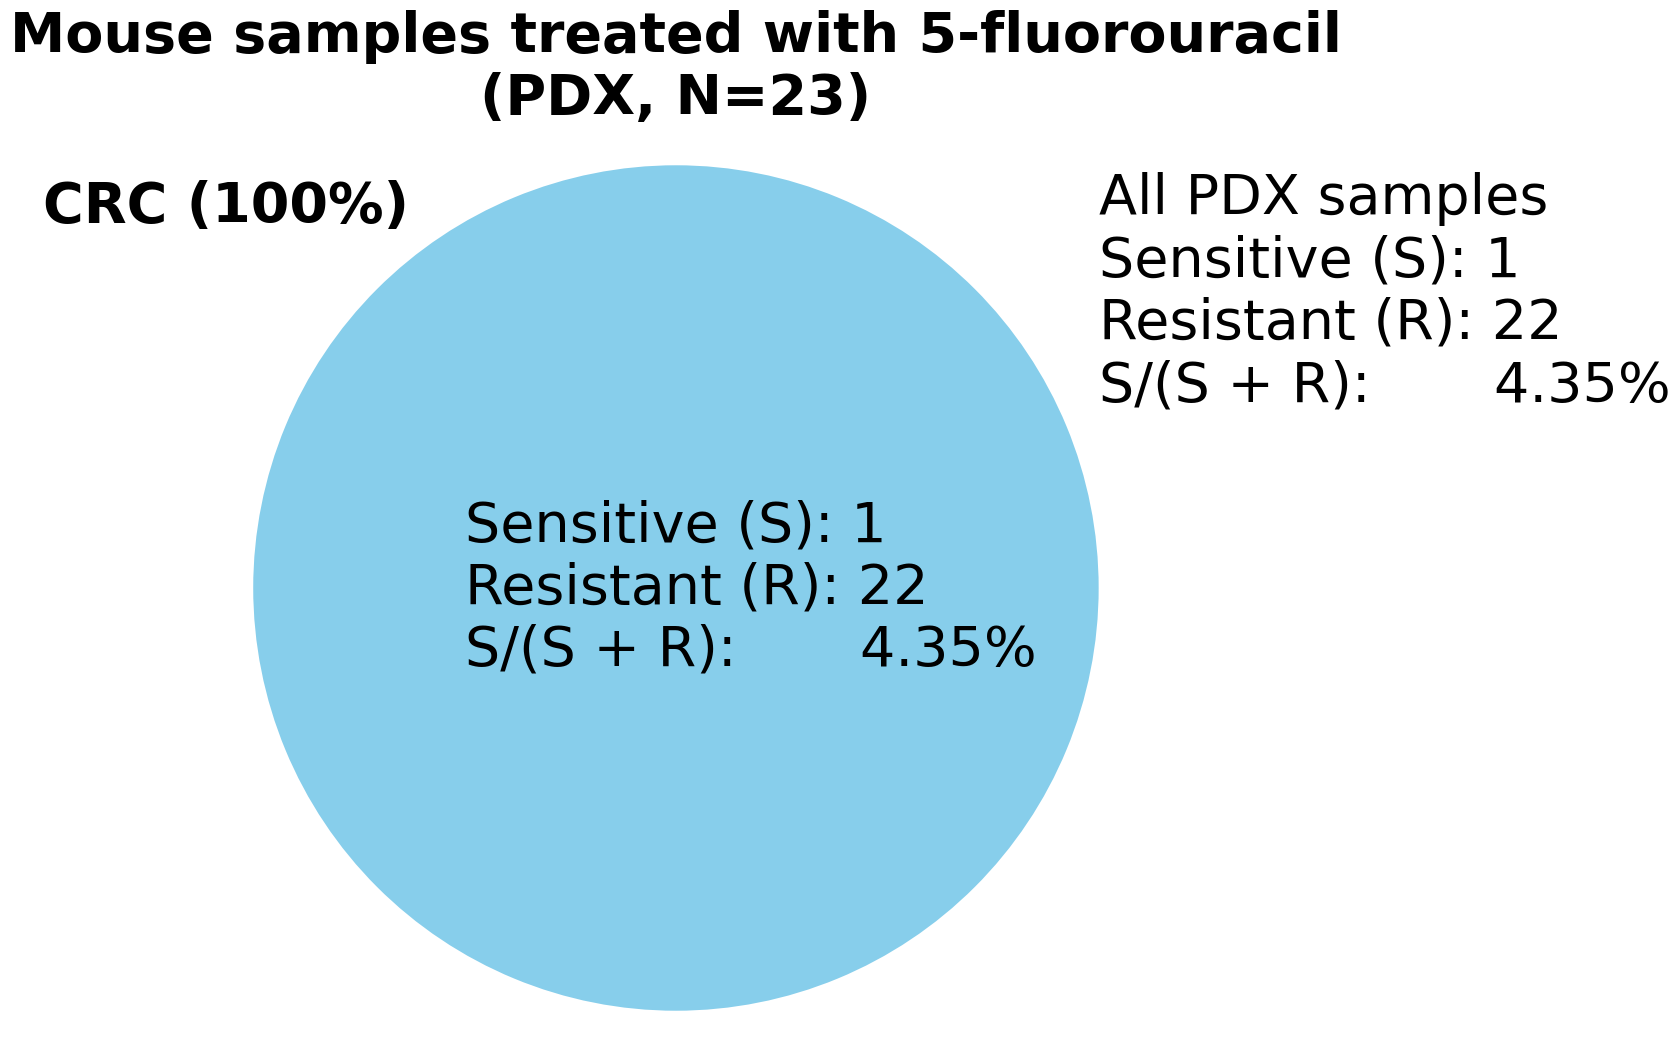

In [52]:
# plot tissue types of PDX samples

labels = list(dat_pdx["Tumor Type"].value_counts().index)
sizes = list(dat_pdx["Tumor Type"].value_counts().astype(int))
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

os.makedirs(save_figures_to, exist_ok=True)

# Create the figure
plt.figure(figsize=(12, 12))
plt.pie(
    sizes, 
    labels=labels_with_percentages, 
    startangle=-55, 
    colors=['skyblue'], 
    textprops={'fontsize': 40, 'fontweight': 'bold'}
)
plt.title(f'Mouse samples treated with 5-fluorouracil\n(PDX, N={total})', fontweight="bold", fontsize=40)
plt.axis('equal')

# Add summary text
plt.text(
    -0.5, 0,
    f'Sensitive (S): {PDXRfluorouracil["response"].value_counts()[1]} \n'
    f'Resistant (R): {PDXRfluorouracil["response"].value_counts()[0]} \n'
    f'S/(S + R):       {round(PDXRfluorouracil["response"].value_counts()[1] / (sum(PDXRfluorouracil["response"].value_counts())) * 100, 2)}%',
    fontsize=40,
    color='black',
    va='center'
)

plt.text(
    1, 0.7,
    f'All PDX samples\nSensitive (S): {PDXRfluorouracil["response"].value_counts()[1]} \n'
    f'Resistant (R): {PDXRfluorouracil["response"].value_counts().get(0, 0)} \n'
    f'S/(S + R):       {round(PDXRfluorouracil["response"].value_counts()[1] / (sum(PDXRfluorouracil["response"].value_counts())) * 100, 2)}%',
    fontsize=40,
    color='black',
    va='center'
)

# Capture the figure object
fig_E = plt.gcf()  # Assign current figure to fig_E

# Save the figure
fig_E.savefig(save_figures_to + 'Tissue_types_of_PDX_samples_5_Fluorouracil.png', format='png', bbox_inches='tight')

# Show the plot
plt.show()

In [53]:
# filter CRC cohort samples (5-Fluorouracil)

filter = (dat_pdx["Tumor Type"] == "CRC")
pdx_crc_samples = dat_pdx.loc[filter,].index
pdx_crc_samples

Index(['X-1027', 'X-1119', 'X-1173', 'X-1270', 'X-1329', 'X-2145', 'X-2182',
       'X-2483', 'X-2538', 'X-2573', 'X-2659', 'X-2846', 'X-2861', 'X-3093',
       'X-3205', 'X-3267', 'X-3671', 'X-3792', 'X-4087', 'X-5405', 'X-5438',
       'X-5495', 'X-5578'],
      dtype='object')

In [54]:
# filter responses of CRC cohort samples (5-Fluorouracil)

Ytsfluorouracil_pdx_crc = PDXRfluorouracil.loc[pdx_crc_samples,"response"].values
Ytsfluorouracil_pdx_crc

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [55]:
# count of sensitive and resistant CRC samples (5-Fluorouracil)

PDXRfluorouracil.loc[pdx_crc_samples,"response"].value_counts()

response
0    22
1     1
Name: count, dtype: int64

In [56]:
# read TCGA response dataset (5-Fluorouracil)

TCGARfluorouracil = pd.read_csv("TCGA_response.Fluorouracil.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
TCGARfluorouracil.dropna(inplace=True)
TCGARfluorouracil.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
TCGARfluorouracil["response"] = TCGARfluorouracil.loc[:, "response"].apply(lambda x: d[x])
Ytsfluorouracil_tcga = TCGARfluorouracil["response"].values    

print(f"There are {Ytsfluorouracil_tcga.shape[0]} samples with response data in the TCGA (5-Fluorouracil)\n")
Ytsfluorouracil_tcga

There are 33 samples with response data in the TCGA (5-Fluorouracil)



array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1])

In [57]:
# TCGA cohort table with TCGA response dataset (5-Fluorouracil)

dat_tcga = TCGARfluorouracil["cohort"]

dat_tcga.value_counts()

cohort
STAD    18
READ     7
PAAD     6
ESCA     2
Name: count, dtype: int64

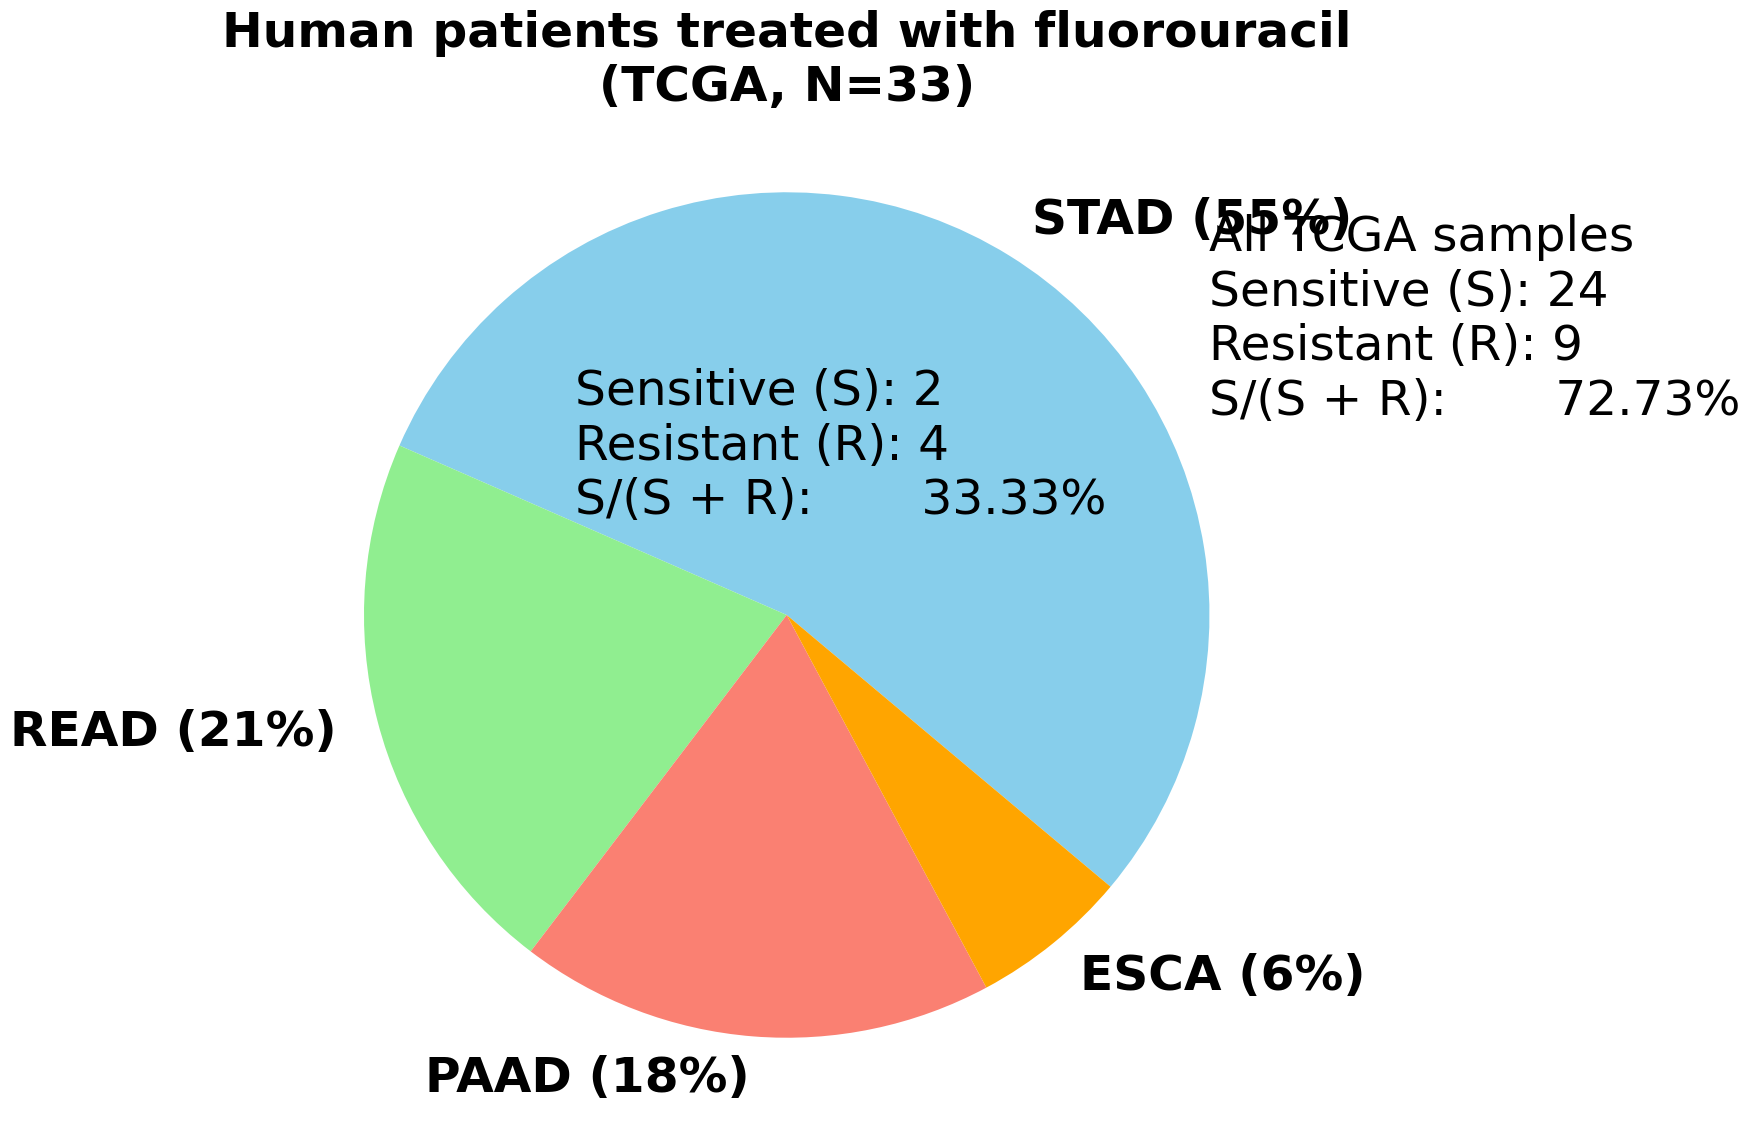

In [58]:
# plot tissue types of TCGA samples

labels = list(dat_tcga.value_counts().index)
sizes = list(dat_tcga.value_counts())
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

# Create the figure
plt.figure(figsize=(12, 12))
plt.pie(
    sizes,
    labels=labels_with_percentages,
    startangle=-40,
    colors=['skyblue', 'lightgreen', 'salmon', 'orange', 'pink'],
    textprops={'fontsize': 35, 'fontweight': 'bold'}
)
plt.title(f'Human patients treated with fluorouracil\n(TCGA, N={total})', fontweight="bold", fontsize=35)
plt.subplots_adjust(top=0.95)
plt.axis('equal')

# Add summary text for PAAD cohort
plt.text(
    -0.5, 0.4,
    f'Sensitive (S): {TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD", "response"].value_counts()[1]} \n'
    f'Resistant (R): {TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD", "response"].value_counts()[0]} \n'
    f'S/(S + R):       {round(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD", "response"].value_counts()[1] / (sum(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD", "response"].value_counts())) * 100, 2)}%',
    fontsize=35,
    color='black',
    va='center'
)

# Add summary text for all TCGA samples
plt.text(
    1, 0.7,
    f'All TCGA samples\nSensitive (S): {TCGARfluorouracil["response"].value_counts()[1]} \n'
    f'Resistant (R): {TCGARfluorouracil["response"].value_counts().get(0, 0)} \n'
    f'S/(S + R):       {round(TCGARfluorouracil["response"].value_counts()[1] / (sum(TCGARfluorouracil["response"].value_counts())) * 100, 2)}%',
    fontsize=35,
    color='black',
    va='center'
)

# Capture the figure object
fig_H = plt.gcf()  # Assign current figure to fig_H

# Save the figure
fig_H.savefig(save_figures_to + 'Tissue_types_of_TCGA_samples_Fluorouracil.png', format='png', bbox_inches='tight')

# Show the plot
plt.show()

In [59]:
# filter STAD cohort samples (5-Fluorouracil)

filter = (TCGARfluorouracil["cohort"] == "STAD")
tcga_stad_samples = dat_tcga.loc[filter,].index
tcga_stad_samples

Index(['TCGA-CG-4444', 'TCGA-D7-8579', 'TCGA-D7-A748', 'TCGA-F1-A448',
       'TCGA-FP-7829', 'TCGA-FP-8209', 'TCGA-HU-8243', 'TCGA-KB-A6F7',
       'TCGA-VQ-A8DT', 'TCGA-VQ-A8DU', 'TCGA-VQ-A8DZ', 'TCGA-VQ-A8E2',
       'TCGA-VQ-A8P3', 'TCGA-VQ-A91Q', 'TCGA-VQ-AA68', 'TCGA-VQ-AA6B',
       'TCGA-VQ-AA6F', 'TCGA-VQ-AA6G'],
      dtype='object')

In [60]:
# filter responses of STAD cohort samples (5-Fluorouracil)

Ytsfluorouracil_tcga_stad = TCGARfluorouracil.loc[tcga_stad_samples,"response"].values
Ytsfluorouracil_tcga_stad

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0])

In [61]:
# count of sensitive and resistance STAD samples (5-Fluorouracil)

TCGARfluorouracil.loc[tcga_stad_samples,"response"].value_counts()

response
1    13
0     5
Name: count, dtype: int64

In [62]:
# filter PAAD cohort samples (5-Fluorouracil)

filter = (TCGARfluorouracil["cohort"] == "PAAD")
tcga_paad_samples = dat_tcga.loc[filter,].index
tcga_paad_samples

Index(['TCGA-3A-A9IC', 'TCGA-3A-A9IX', 'TCGA-HZ-7920', 'TCGA-HZ-A49I',
       'TCGA-IB-7888', 'TCGA-OE-A75W'],
      dtype='object')

In [63]:
# filter responses of PAAD cohort samples (5-Fluorouracil)

Ytsfluorouracil_tcga_paad = TCGARfluorouracil.loc[tcga_paad_samples,"response"].values
Ytsfluorouracil_tcga_paad

array([0, 1, 1, 0, 0, 0])

In [64]:
# count of sensitive and resistance _paad samples (5-Fluorouracil)

TCGARfluorouracil.loc[tcga_paad_samples,"response"].value_counts()

response
0    4
1    2
Name: count, dtype: int64

In [65]:
# maximum iteration

max_iter = 50

In [66]:
# use count of nodes and dropout rates found in trained pan-drug dataset

hdm1 = 16
hdm2 = 16
rate1 = 0.4
rate2 = 0.3
rate3 = 0.3

In [67]:
# load pre-trained modules and make predictions

scalerGDSC = sk.StandardScaler()
scalerGDSC.fit(GDSCEv2.values)
X_trainE = scalerGDSC.transform(GDSCEv2.values)
X_testEfluorouracil_pdx = scalerGDSC.transform(PDXEfluorouracil.values) 
X_testEfluorouracil_pdx_crc = scalerGDSC.transform(PDXEfluorouracil.loc[pdx_crc_samples,].values) 

X_testEfluorouracil_tcga = scalerGDSC.transform(TCGAEfluorouracil.values)    
X_testEfluorouracil_tcga_stad = scalerGDSC.transform(TCGAEfluorouracil.loc[tcga_stad_samples,].values)    
X_testEfluorouracil_tcga_paad = scalerGDSC.transform(TCGAEfluorouracil.loc[tcga_paad_samples,].values)    

X_trainM = np.nan_to_num(GDSCMv2.values)
X_testMfluorouracil_pdx = np.nan_to_num(PDXMfluorouracil.values.astype(np.float32))
X_testMfluorouracil_pdx_crc = np.nan_to_num(PDXMfluorouracil.loc[pdx_crc_samples,].values.astype(np.float32))
X_testMfluorouracil_tcga = np.nan_to_num(TCGAMfluorouracil.values.astype(np.float32))
X_testMfluorouracil_tcga_stad = np.nan_to_num(TCGAMfluorouracil.loc[tcga_stad_samples,].values)
X_testMfluorouracil_tcga_paad = np.nan_to_num(TCGAMfluorouracil.loc[tcga_paad_samples,].values.astype(np.float32))

TX_testEfluorouracil_pdx = torch.FloatTensor(X_testEfluorouracil_pdx)
TX_testEfluorouracil_pdx_crc = torch.FloatTensor(X_testEfluorouracil_pdx_crc)

TX_testMfluorouracil_pdx = torch.FloatTensor(X_testMfluorouracil_pdx.astype(np.float32))
TX_testMfluorouracil_pdx_crc = torch.FloatTensor(X_testMfluorouracil_pdx_crc.astype(np.float32))

ty_testEfluorouracil_pdx = torch.FloatTensor(Ytsfluorouracil_pdx.astype(int))
ty_testEfluorouracil_pdx_crc = torch.FloatTensor(Ytsfluorouracil_pdx_crc.astype(int))

TX_testEfluorouracil_tcga = torch.FloatTensor(X_testEfluorouracil_tcga)
TX_testEfluorouracil_tcga_stad = torch.FloatTensor(X_testEfluorouracil_tcga_stad)
TX_testEfluorouracil_tcga_paad = torch.FloatTensor(X_testEfluorouracil_tcga_paad)

TX_testMfluorouracil_tcga = torch.FloatTensor(X_testMfluorouracil_tcga.astype(np.float32))
TX_testMfluorouracil_tcga_stad = torch.FloatTensor(X_testMfluorouracil_tcga_stad.astype(np.float32))
TX_testMfluorouracil_tcga_paad = torch.FloatTensor(X_testMfluorouracil_tcga_paad.astype(np.float32))

ty_testEfluorouracil_tcga = torch.FloatTensor(Ytsfluorouracil_tcga.astype(int))
ty_testEfluorouracil_tcga_stad = torch.FloatTensor(Ytsfluorouracil_tcga_stad.astype(int))
ty_testEfluorouracil_tcga_paad = torch.FloatTensor(Ytsfluorouracil_tcga_paad.astype(int))

n_sampE, IE_dim = X_trainE.shape
n_sampM, IM_dim = X_trainM.shape

h_dim1 = hdm1
h_dim2 = hdm2
Z_in = h_dim1 + h_dim2

class AEE(nn.Module):
    def __init__(self):
        super(AEE, self).__init__()
        self.EnE = torch.nn.Sequential(
            nn.Linear(IE_dim, h_dim1),
            nn.BatchNorm1d(h_dim1),
            nn.ReLU(),
            nn.Dropout(rate1))
    def forward(self, x):
        output = self.EnE(x)
        return output  


class AEM(nn.Module):
    def __init__(self):
        super(AEM, self).__init__()
        self.EnM = torch.nn.Sequential(
            nn.Linear(IM_dim, h_dim2),
            nn.BatchNorm1d(h_dim2),
            nn.ReLU(),
            nn.Dropout(rate2))
    def forward(self, x):
        output = self.EnM(x)
        return output       
        
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.FC = torch.nn.Sequential(
            nn.Linear(Z_in, 1),
            nn.Dropout(rate3),
            nn.Sigmoid())
    def forward(self, x):
        return self.FC(x)

torch.cuda.manual_seed_all(42)

AutoencoderE = torch.load(models_dir + "Exprs_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Second_Strategy.pt")
AutoencoderM = torch.load(models_dir + "Mut_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Second_Strategy.pt")

Clas = torch.load(models_dir + "Class_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Second_Strategy.pt")

AutoencoderE.eval()
AutoencoderM.eval()
Clas.eval()

ZEX = AutoencoderE(torch.FloatTensor(X_trainE))
ZMX = AutoencoderM(torch.FloatTensor(X_trainM))
ZTX = torch.cat((ZEX, ZMX), 1)
ZTX = F.normalize(ZTX, p=2, dim=0)
PredX = Clas(ZTX)
AUCT = roc_auc_score(Y, PredX.detach().numpy())
AUCTaucpr = average_precision_score(Y, PredX.detach().numpy())

ZETfluorouracil_pdx = AutoencoderE(TX_testEfluorouracil_pdx)
ZMTfluorouracil_pdx = AutoencoderM(TX_testMfluorouracil_pdx)
ZTTfluorouracil_pdx = torch.cat((ZETfluorouracil_pdx, ZMTfluorouracil_pdx), 1)
ZTTfluorouracil_pdx = F.normalize(ZTTfluorouracil_pdx, p=2, dim=0)
PredTfluorouracil_pdx = Clas(ZTTfluorouracil_pdx)
AUCTfluorouracil_pdx = roc_auc_score(Ytsfluorouracil_pdx.astype(int), PredTfluorouracil_pdx.detach().numpy())
AUCTfluorouracil_pdx_aucpr = average_precision_score(Ytsfluorouracil_pdx.astype(int), PredTfluorouracil_pdx.detach().numpy())

ZETfluorouracil_pdx_crc = AutoencoderE(TX_testEfluorouracil_pdx_crc)
ZMTfluorouracil_pdx_crc = AutoencoderM(TX_testMfluorouracil_pdx_crc)
ZTTfluorouracil_pdx_crc = torch.cat((ZETfluorouracil_pdx_crc, ZMTfluorouracil_pdx_crc), 1)
ZTTfluorouracil_pdx_crc = F.normalize(ZTTfluorouracil_pdx_crc, p=2, dim=0)
PredTfluorouracil_pdx_crc = Clas(ZTTfluorouracil_pdx_crc)
AUCTfluorouracil_pdx_crc = roc_auc_score(Ytsfluorouracil_pdx_crc.astype(int), PredTfluorouracil_pdx_crc.detach().numpy())
AUCTfluorouracil_pdx_crc_aucpr = average_precision_score(Ytsfluorouracil_pdx_crc.astype(int), PredTfluorouracil_pdx_crc.detach().numpy())

ZETfluorouracil_tcga = AutoencoderE(TX_testEfluorouracil_tcga)
ZMTfluorouracil_tcga = AutoencoderM(TX_testMfluorouracil_tcga)
ZTTfluorouracil_tcga = torch.cat((ZETfluorouracil_tcga, ZMTfluorouracil_tcga), 1)
ZTTfluorouracil_tcga = F.normalize(ZTTfluorouracil_tcga, p=2, dim=0)
PredTfluorouracil_tcga = Clas(ZTTfluorouracil_tcga)
AUCTfluorouracil_tcga = roc_auc_score(Ytsfluorouracil_tcga.astype(int), PredTfluorouracil_tcga.detach().numpy())
AUCTfluorouracil_tcga_aucpr = average_precision_score(Ytsfluorouracil_tcga.astype(int), PredTfluorouracil_tcga.detach().numpy())

ZETfluorouracil_tcga_stad = AutoencoderE(TX_testEfluorouracil_tcga_stad)
ZMTfluorouracil_tcga_stad = AutoencoderM(TX_testMfluorouracil_tcga_stad)
ZTTfluorouracil_tcga_stad = torch.cat((ZETfluorouracil_tcga_stad, ZMTfluorouracil_tcga_stad), 1)
ZTTfluorouracil_tcga_stad = F.normalize(ZTTfluorouracil_tcga_stad, p=2, dim=0)
PredTfluorouracil_tcga_stad = Clas(ZTTfluorouracil_tcga_stad)
AUCTfluorouracil_tcga_stad = roc_auc_score(Ytsfluorouracil_tcga_stad.astype(int), PredTfluorouracil_tcga_stad.detach().numpy())
AUCTfluorouracil_tcga_stad_aucpr = average_precision_score(Ytsfluorouracil_tcga_stad.astype(int), PredTfluorouracil_tcga_stad.detach().numpy())

ZETfluorouracil_tcga_paad = AutoencoderE(TX_testEfluorouracil_tcga_paad)
ZMTfluorouracil_tcga_paad = AutoencoderM(TX_testMfluorouracil_tcga_paad)
ZTTfluorouracil_tcga_paad = torch.cat((ZETfluorouracil_tcga_paad, ZMTfluorouracil_tcga_paad), 1)
ZTTfluorouracil_tcga_paad = F.normalize(ZTTfluorouracil_tcga_paad, p=2, dim=0)
PredTfluorouracil_tcga_paad = Clas(ZTTfluorouracil_tcga_paad)
AUCTfluorouracil_tcga_paad = roc_auc_score(Ytsfluorouracil_tcga_paad.astype(int), PredTfluorouracil_tcga_paad.detach().numpy())
AUCTfluorouracil_tcga_paad_aucpr = average_precision_score(Ytsfluorouracil_tcga_paad.astype(int), PredTfluorouracil_tcga_paad.detach().numpy())

AUCT_finetuned = dict()
AUCTaucpr_finetuned = dict()
AUCTfluorouracil_pdx_finetuned = dict()
AUCTfluorouracil_tcga_finetuned = dict()
AUCTfluorouracil_pdx_crc_finetuned = dict()
AUCTfluorouracil_tcga_stad_finetuned = dict()
AUCTfluorouracil_tcga_paad_finetuned = dict()
AUCTfluorouracil_pdx_aucpr_finetuned = dict()
AUCTfluorouracil_tcga_aucpr_finetuned = dict()
AUCTfluorouracil_pdx_crc_aucpr_finetuned = dict()
AUCTfluorouracil_tcga_stad_aucpr_finetuned = dict()
AUCTfluorouracil_tcga_paad_aucpr_finetuned = dict()
for iter in range(max_iter):
   iter += 1  

   AutoencoderE_finetuned = torch.load(finetuned_dir + f"Exprs_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Second_Strategy_Finetuned_{iter}.pt")
   AutoencoderM_finetuned = torch.load(finetuned_dir + f"Mut_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Second_Strategy_Finetuned_{iter}.pt")
   Clas_finetuned = torch.load(finetuned_dir + f"Class_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Second_Strategy_Finetuned_{iter}.pt")
   
   AutoencoderE_finetuned.eval()
   AutoencoderM_finetuned.eval()
   Clas_finetuned.eval()
      
   ZEX = AutoencoderE_finetuned(torch.FloatTensor(X_trainE))
   ZMX = AutoencoderM_finetuned(torch.FloatTensor(X_trainM))
   ZTX = torch.cat((ZEX, ZMX), 1)
   ZTX = F.normalize(ZTX, p=2, dim=0)
   PredX = Clas_finetuned(ZTX)
   AUCT_finetuned[iter] = roc_auc_score(Y, PredX.detach().numpy())
   AUCTaucpr_finetuned[iter] = average_precision_score(Y, PredX.detach().numpy())
   
   ZETfluorouracil_pdx = AutoencoderE_finetuned(TX_testEfluorouracil_pdx)
   ZMTfluorouracil_pdx = AutoencoderM_finetuned(TX_testMfluorouracil_pdx)
   ZTTfluorouracil_pdx = torch.cat((ZETfluorouracil_pdx, ZMTfluorouracil_pdx), 1)
   ZTTfluorouracil_pdx = F.normalize(ZTTfluorouracil_pdx, p=2, dim=0)
   PredTfluorouracil_pdx = Clas_finetuned(ZTTfluorouracil_pdx)
   AUCTfluorouracil_pdx_finetuned[iter] = roc_auc_score(Ytsfluorouracil_pdx.astype(int), PredTfluorouracil_pdx.detach().numpy())
   AUCTfluorouracil_pdx_aucpr_finetuned[iter] = average_precision_score(Ytsfluorouracil_pdx.astype(int), PredTfluorouracil_pdx.detach().numpy())

   ZETfluorouracil_pdx_crc = AutoencoderE_finetuned(TX_testEfluorouracil_pdx_crc)
   ZMTfluorouracil_pdx_crc = AutoencoderM_finetuned(TX_testMfluorouracil_pdx_crc)
   ZTTfluorouracil_pdx_crc = torch.cat((ZETfluorouracil_pdx_crc, ZMTfluorouracil_pdx_crc), 1)
   ZTTfluorouracil_pdx_crc = F.normalize(ZTTfluorouracil_pdx_crc, p=2, dim=0)
   PredTfluorouracil_pdx_crc = Clas_finetuned(ZTTfluorouracil_pdx_crc)
   AUCTfluorouracil_pdx_crc_finetuned[iter] = roc_auc_score(Ytsfluorouracil_pdx_crc.astype(int), PredTfluorouracil_pdx_crc.detach().numpy())
   AUCTfluorouracil_pdx_crc_aucpr_finetuned[iter] = average_precision_score(Ytsfluorouracil_pdx_crc.astype(int), PredTfluorouracil_pdx_crc.detach().numpy())

   ZETfluorouracil_tcga = AutoencoderE_finetuned(TX_testEfluorouracil_tcga)
   ZMTfluorouracil_tcga = AutoencoderM_finetuned(TX_testMfluorouracil_tcga)
   ZTTfluorouracil_tcga = torch.cat((ZETfluorouracil_tcga, ZMTfluorouracil_tcga), 1)
   ZTTfluorouracil_tcga = F.normalize(ZTTfluorouracil_tcga, p=2, dim=0)
   PredTfluorouracil_tcga = Clas_finetuned(ZTTfluorouracil_tcga)
   AUCTfluorouracil_tcga_finetuned[iter] = roc_auc_score(Ytsfluorouracil_tcga.astype(int), PredTfluorouracil_tcga.detach().numpy())
   AUCTfluorouracil_tcga_aucpr_finetuned[iter] = average_precision_score(Ytsfluorouracil_tcga.astype(int), PredTfluorouracil_tcga.detach().numpy())

   ZETfluorouracil_tcga_stad = AutoencoderE_finetuned(TX_testEfluorouracil_tcga_stad)
   ZMTfluorouracil_tcga_stad = AutoencoderM_finetuned(TX_testMfluorouracil_tcga_stad)
   ZTTfluorouracil_tcga_stad = torch.cat((ZETfluorouracil_tcga_stad, ZMTfluorouracil_tcga_stad), 1)
   ZTTfluorouracil_tcga_stad = F.normalize(ZTTfluorouracil_tcga_stad, p=2, dim=0)
   PredTfluorouracil_tcga_stad = Clas_finetuned(ZTTfluorouracil_tcga_stad)
   AUCTfluorouracil_tcga_stad_finetuned[iter] = roc_auc_score(Ytsfluorouracil_tcga_stad.astype(int), PredTfluorouracil_tcga_stad.detach().numpy())
   AUCTfluorouracil_tcga_stad_aucpr_finetuned[iter] = average_precision_score(Ytsfluorouracil_tcga_stad.astype(int), PredTfluorouracil_tcga_stad.detach().numpy())
    
   ZETfluorouracil_tcga_paad = AutoencoderE_finetuned(TX_testEfluorouracil_tcga_paad)
   ZMTfluorouracil_tcga_paad = AutoencoderM_finetuned(TX_testMfluorouracil_tcga_paad)
   ZTTfluorouracil_tcga_paad = torch.cat((ZETfluorouracil_tcga_paad, ZMTfluorouracil_tcga_paad), 1)
   ZTTfluorouracil_tcga_paad = F.normalize(ZTTfluorouracil_tcga_paad, p=2, dim=0)
   PredTfluorouracil_tcga_paad = Clas_finetuned(ZTTfluorouracil_tcga_paad)
   AUCTfluorouracil_tcga_paad_finetuned[iter] = roc_auc_score(Ytsfluorouracil_tcga_paad.astype(int), PredTfluorouracil_tcga_paad.detach().numpy())
   AUCTfluorouracil_tcga_paad_aucpr_finetuned[iter] = average_precision_score(Ytsfluorouracil_tcga_paad.astype(int), PredTfluorouracil_tcga_paad.detach().numpy())

max_key_pdx = max(AUCTfluorouracil_pdx_aucpr_finetuned, key=AUCTfluorouracil_pdx_aucpr_finetuned.get)
max_key_pdx_crc = max(AUCTfluorouracil_pdx_crc_aucpr_finetuned, key=AUCTfluorouracil_pdx_crc_aucpr_finetuned.get)
max_key_tcga = max(AUCTfluorouracil_tcga_aucpr_finetuned, key=AUCTfluorouracil_tcga_aucpr_finetuned.get)
max_key_tcga_stad = max(AUCTfluorouracil_tcga_stad_aucpr_finetuned, key=AUCTfluorouracil_tcga_stad_aucpr_finetuned.get)
max_key_tcga_paad = max(AUCTfluorouracil_tcga_paad_aucpr_finetuned, key=AUCTfluorouracil_tcga_paad_aucpr_finetuned.get)

print(f"GDSC - Training AUC (DNA_REPi): {round(AUCT,2)}")
print(f"GDSC - Training AUCPR (DNA_REPi): {round(AUCTaucpr,2)}")
print(f"PDX - Test AUC (5-Fluorouracil): {round(AUCTfluorouracil_pdx,2)}")
print(f"PDX - Test AUCPR (5-Fluorouracil): {round(AUCTfluorouracil_pdx_aucpr,2)}")
print(f"PDX - Test AUC (5-Fluorouracil, CRC): {round(AUCTfluorouracil_pdx_crc,2)}")
print(f"PDX - Test AUCPR (5-Fluorouracil, CRC): {round(AUCTfluorouracil_pdx_crc_aucpr,2)}")
print(f"TCGA - Test AUC (5-Fluorouracil): {round(AUCTfluorouracil_tcga,2)}")
print(f"TCGA - Test AUCPR (5-Fluorouracil): {round(AUCTfluorouracil_tcga_aucpr,2)}")
print(f"TCGA - Test AUC (5-Fluorouracil, STAD): {round(AUCTfluorouracil_tcga_stad,2)}")
print(f"TCGA - Test AUCPR (5-Fluorouracil, STAD): {round(AUCTfluorouracil_tcga_stad_aucpr,2)}")
print(f"TCGA - Test AUC (5-Fluorouracil, PAAD): {round(AUCTfluorouracil_tcga_paad,2)}")
print(f"TCGA - Test AUCPR (5-Fluorouracil, PAAD): {round(AUCTfluorouracil_tcga_paad_aucpr,2)}\n")

print(f"GDSC - Training AUC (DNA_REPi, Finetuned): {round(AUCT_finetuned[max_key_pdx],2)}")
print(f"GDSC - Training AUCPR (DNA_REPi, Finetuned): {round(AUCTaucpr_finetuned[max_key_pdx],2)}")
print(f"PDX - Test AUC (5-Fluorouracil, Finetuned): {round(AUCTfluorouracil_pdx_finetuned[max_key_pdx],2)}")
print(f"PDX - Test AUCPR (5-Fluorouracil, Finetuned): {round(AUCTfluorouracil_pdx_aucpr_finetuned[max_key_pdx],2)}\n")

print(f"GDSC - Training AUC (DNA_REPi, Finetuned): {round(AUCT_finetuned[max_key_pdx_crc],2)}")
print(f"GDSC - Training AUCPR (DNA_REPi, Finetuned): {round(AUCTaucpr_finetuned[max_key_pdx_crc],2)}")
print(f"PDX - Test AUC (5-Fluorouracil, CRC, Finetuned): {round(AUCTfluorouracil_pdx_crc_finetuned[max_key_pdx_crc],2)}")
print(f"PDX - Test AUCPR (5-Fluorouracil, CRC, Finetuned): {round(AUCTfluorouracil_pdx_crc_aucpr_finetuned[max_key_pdx_crc],2)}\n")

print(f"GDSC - Training AUC (DNA_REPi, Finetuned): {round(AUCT_finetuned[max_key_tcga],2)}")
print(f"GDSC - Training AUCPR (DNA_REPi, Finetuned): {round(AUCTaucpr_finetuned[max_key_tcga],2)}")
print(f"TCGA - Test AUC (5-Fluorouracil, Finetuned): {round(AUCTfluorouracil_tcga_finetuned[max_key_tcga],2)}")
print(f"TCGA - Test AUCPR (5-Fluorouracil, Finetuned): {round(AUCTfluorouracil_tcga_aucpr_finetuned[max_key_tcga],2)}\n")

print(f"GDSC - Training AUC (DNA_REPi, Finetuned): {round(AUCT_finetuned[max_key_tcga_stad],2)}")
print(f"GDSC - Training AUCPR (DNA_REPi, Finetuned): {round(AUCTaucpr_finetuned[max_key_tcga_stad],2)}")
print(f"TCGA - Test AUC (5-Fluorouracil, STAD, Finetuned): {round(AUCTfluorouracil_tcga_stad_finetuned[max_key_tcga_stad],2)}")
print(f"TCGA - Test AUCPR (5-Fluorouracil, STAD, Finetuned): {round(AUCTfluorouracil_tcga_stad_aucpr_finetuned[max_key_tcga_stad],2)}\n")

print(f"GDSC - Training AUC (DNA_REPi, Finetuned): {round(AUCT_finetuned[max_key_tcga_paad],2)}")
print(f"GDSC - Training AUCPR (DNA_REPi, Finetuned): {round(AUCTaucpr_finetuned[max_key_tcga_paad],2)}")
print(f"TCGA - Test AUC (5-Fluorouracil, PAAD, Finetuned): {round(AUCTfluorouracil_tcga_paad_finetuned[max_key_tcga_paad],2)}")
print(f"TCGA - Test AUCPR (5-Fluorouracil, PAAD, Finetuned): {round(AUCTfluorouracil_tcga_paad_aucpr_finetuned[max_key_tcga_paad],2)}\n\n")

print("Models for maximum finetuning (5-Fluorouracil, PDX)")
print(f"Exprs_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx}.pt")
print(f"Mut_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx}.pt")
print(f"Class_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx}.pt")

print("\nModels for maximum finetuning (5-Fluorouracil, PDX, CRC)")
print(f"Exprs_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx_crc}.pt")
print(f"Mut_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx_crc}.pt")
print(f"Class_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx_crc}.pt")

print("\nModels for maximum finetuning (5-Fluorouracil, TCGA)")
print(f"Exprs_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_tcga}.pt")
print(f"Mut_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_tcga}.pt")
print(f"Class_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_tcga}.pt")

print("\nModels for maximum finetuning (5-Fluorouracil, TCGA, STAD)")
print(f"Exprs_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Finetuned_{max_key_tcga_stad}.pt")
print(f"Mut_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Finetuned_{max_key_tcga_stad}.pt")
print(f"Class_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Finetuned_{max_key_tcga_stad}.pt")

print("\nModels for maximum finetuning (5-Fluorouracil, TCGA, PAAD)")
print(f"Exprs_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_tcga_paad}.pt")
print(f"Mut_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_tcga_paad}.pt")
print(f"Class_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_tcga_paad}.pt")


GDSC - Training AUC (DNA_REPi): 0.82
GDSC - Training AUCPR (DNA_REPi): 0.33
PDX - Test AUC (5-Fluorouracil): 0.18
PDX - Test AUCPR (5-Fluorouracil): 0.05
PDX - Test AUC (5-Fluorouracil, CRC): 0.18
PDX - Test AUCPR (5-Fluorouracil, CRC): 0.05
TCGA - Test AUC (5-Fluorouracil): 0.65
TCGA - Test AUCPR (5-Fluorouracil): 0.82
TCGA - Test AUC (5-Fluorouracil, STAD): 0.72
TCGA - Test AUCPR (5-Fluorouracil, STAD): 0.91
TCGA - Test AUC (5-Fluorouracil, PAAD): 0.5
TCGA - Test AUCPR (5-Fluorouracil, PAAD): 0.45

GDSC - Training AUC (DNA_REPi, Finetuned): 0.82
GDSC - Training AUCPR (DNA_REPi, Finetuned): 0.33
PDX - Test AUC (5-Fluorouracil, Finetuned): 0.36
PDX - Test AUCPR (5-Fluorouracil, Finetuned): 0.07

GDSC - Training AUC (DNA_REPi, Finetuned): 0.82
GDSC - Training AUCPR (DNA_REPi, Finetuned): 0.33
PDX - Test AUC (5-Fluorouracil, CRC, Finetuned): 0.36
PDX - Test AUCPR (5-Fluorouracil, CRC, Finetuned): 0.07

GDSC - Training AUC (DNA_REPi, Finetuned): 0.81
GDSC - Training AUCPR (DNA_REPi, Finet

In [68]:
# show expression layer parameters

AutoencoderE

AEE(
  (EnE): Sequential(
    (0): Linear(in_features=684, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
  )
)

In [69]:
# show mutation layer parameters

AutoencoderM

AEM(
  (EnM): Sequential(
    (0): Linear(in_features=684, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
)

In [70]:
# show classification layer parameters

Clas

Classifier(
  (FC): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Sigmoid()
  )
)

In [71]:
# create a dataframe with the prediction results 

em  = {"Data": ["Expr + Mut", "Expr + Mut (Fine-tuned)"],
       "AUC (GDSC)": [round(AUCT, 2), round(AUCT_finetuned[max_key_pdx], 2)],
       "AUCPR (GDSC)": [round(AUCTaucpr,2), round(AUCTaucpr_finetuned[max_key_pdx],2)],
       "AUC (PDX)": [round(AUCTfluorouracil_pdx,2), round(AUCTfluorouracil_pdx_finetuned[max_key_pdx],2)],
       "AUCPR (PDX)":  [round(AUCTfluorouracil_pdx_aucpr,2), round(AUCTfluorouracil_pdx_aucpr_finetuned[max_key_pdx],2)],
       "AUC (PDX-CRC)":  [round(AUCTfluorouracil_pdx_crc,2), round(AUCTfluorouracil_pdx_crc_finetuned[max_key_pdx_crc],2)],
       "AUCPR (PDX-CRC)": [round(AUCTfluorouracil_pdx_crc_aucpr,2), round(AUCTfluorouracil_pdx_crc_aucpr_finetuned[max_key_pdx_crc],2)],
       "AUC (TCGA)": [round(AUCTfluorouracil_tcga,2), round(AUCTfluorouracil_tcga_finetuned[max_key_tcga],2)],
       "AUCPR (TCGA)":  [round(AUCTfluorouracil_tcga_aucpr,2), round(AUCTfluorouracil_tcga_aucpr_finetuned[max_key_tcga],2)],
       "AUC (TCGA-STAD)":  [round(AUCTfluorouracil_tcga_stad,2), round(AUCTfluorouracil_tcga_stad_finetuned[max_key_tcga_stad],2)],
       "AUCPR (TCGA-STAD)": [round(AUCTfluorouracil_tcga_stad_aucpr,2), round(AUCTfluorouracil_tcga_stad_aucpr_finetuned[max_key_tcga_stad],2)],
       "AUC (TCGA-PAAD)":  [round(AUCTfluorouracil_tcga_paad,2), round(AUCTfluorouracil_tcga_paad_finetuned[max_key_tcga_paad],2)],
       "AUCPR (TCGA-PAAD)": [round(AUCTfluorouracil_tcga_paad_aucpr,2), round(AUCTfluorouracil_tcga_paad_aucpr_finetuned[max_key_tcga_paad],2)],
       "Sample Size (GDSC)": [GDSCEv2.shape[0], GDSCEv2.shape[0]],
       "Feature Size (GDSC)": [GDSCEv2.shape[1], GDSCEv2.shape[1]] 
}

em_dataframe = pd.DataFrame.from_dict(em, orient='index').transpose() 
os.makedirs(save_results_to, exist_ok = True)
em_dataframe.to_csv(save_results_to + "GDSC_PDX_TCGA_Expression_Mutation_DNA_REPi_Fluorouracil_Second_Strategy.tsv",
                     sep = "\t",
                     index = False)

em_dataframe.rename(columns = {
    "AUC (GDSC)": "AUC (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUCPR (GDSC)": "AUCPR (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUC (PDX)": "AUC (PDX, N=" + str(len(Ytsfluorouracil_pdx)) + ")",
    "AUCPR (PDX)": "AUCPR (PDX, N=" + str(len(Ytsfluorouracil_pdx)) + ")",
    "AUC (PDX-CRC)": "AUC (PDX-CRC, N=" + str(len(Ytsfluorouracil_pdx_crc)) + ")",
    "AUCPR (PDX-CRC)": "AUCPR (PDX-CRC, N=" + str(len(Ytsfluorouracil_pdx_crc)) + ")",
    "AUC (TCGA)": "AUC (TCGA, N=" + str(len(Ytsfluorouracil_tcga)) + ")",
    "AUCPR (TCGA)": "AUCPR (TCGA, N=" + str(len(Ytsfluorouracil_tcga)) + ")",
    "AUC (TCGA-STAD)": "AUC (TCGA-STAD, N=" + str(len(Ytsfluorouracil_tcga_stad)) + ")",
    "AUCPR (TCGA-STAD)": "AUCPR (TCGA-STAD, N=" + str(len(Ytsfluorouracil_tcga_stad)) + ")",
    "AUC (TCGA-PAAD)": "AUC (TCGA-PAAD, N=" + str(len(Ytsfluorouracil_tcga_paad)) + ")",
    "AUCPR (TCGA-PAAD)": "AUCPR (TCGA-PAAD, N=" + str(len(Ytsfluorouracil_tcga_paad)) + ")"
    }, inplace = True
)

em_dataframe

,Data,"AUC (GDSC, N=9435)","AUCPR (GDSC, N=9435)","AUC (PDX, N=23)","AUCPR (PDX, N=23)","AUC (PDX-CRC, N=23)","AUCPR (PDX-CRC, N=23)","AUC (TCGA, N=33)","AUCPR (TCGA, N=33)","AUC (TCGA-STAD, N=18)","AUCPR (TCGA-STAD, N=18)","AUC (TCGA-PAAD, N=6)","AUCPR (TCGA-PAAD, N=6)",Sample Size (GDSC),Feature Size (GDSC)
0,Expr + Mut,0.82,0.33,0.18,0.05,0.18,0.05,0.65,0.82,0.72,0.91,0.5,0.45,9435,684
1,Expr + Mut (Fine-tuned),0.82,0.33,0.36,0.07,0.36,0.07,0.67,0.85,0.75,0.92,0.75,0.75,9435,684


In [72]:
# merge all EM, EC, and EMC dataframes 

ec_dataframe = pd.read_csv(ec_dir + "GDSC_PDX_TCGA_Expression_CNA_DNA_REPi_Fluorouracil_Second_Strategy.tsv",
                           sep = "\t")
ec_dataframe.columns = em_dataframe.columns

emc_dataframe = pd.read_csv(emc_dir + "GDSC_PDX_TCGA_Expression_Mutation_CNA_DNA_REPi_Fluorouracil_Second_Strategy.tsv",
                           sep = "\t")
emc_dataframe.columns = em_dataframe.columns

all_dataframe = pd.concat([emc_dataframe, ec_dataframe, em_dataframe], axis = 0)
all_dataframe.set_index("Data", inplace = True)

all_dataframe

,"AUC (GDSC, N=9435)","AUCPR (GDSC, N=9435)","AUC (PDX, N=23)","AUCPR (PDX, N=23)","AUC (PDX-CRC, N=23)","AUCPR (PDX-CRC, N=23)","AUC (TCGA, N=33)","AUCPR (TCGA, N=33)","AUC (TCGA-STAD, N=18)","AUCPR (TCGA-STAD, N=18)","AUC (TCGA-PAAD, N=6)","AUCPR (TCGA-PAAD, N=6)",Sample Size (GDSC),Feature Size (GDSC)
Data,,,,,,,,,,,,,,
Expr + Mut + CNA,0.81,0.34,0.14,0.05,0.14,0.05,0.53,0.74,0.75,0.89,0.25,0.32,9435,631
Expr + Mut + CNA (Fine-tuned),0.81,0.34,0.18,0.05,0.18,0.05,0.57,0.78,0.74,0.9,0.5,0.45,9435,631
Expr + CNA,0.81,0.33,0.14,0.05,0.14,0.05,0.4,0.75,0.49,0.81,0.0,0.27,9435,750
Expr + CNA (Fine-tuned),0.81,0.33,0.18,0.05,0.18,0.05,0.41,0.75,0.51,0.81,0.0,0.27,9435,750
Expr + Mut,0.82,0.33,0.18,0.05,0.18,0.05,0.65,0.82,0.72,0.91,0.5,0.45,9435,684
Expr + Mut (Fine-tuned),0.82,0.33,0.36,0.07,0.36,0.07,0.67,0.85,0.75,0.92,0.75,0.75,9435,684


In [73]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

auc_dataframe = all_dataframe[[f"AUC (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUC (PDX, N={str(len(Ytsfluorouracil_pdx))})",
                               f"AUC (PDX-CRC, N={str(len(Ytsfluorouracil_pdx_crc))})",
                               f"AUC (TCGA, N={str(len(Ytsfluorouracil_tcga))})",
                               f"AUC (TCGA-STAD, N={str(len(Ytsfluorouracil_tcga_stad))})",
                               f"AUC (TCGA-PAAD, N={str(len(Ytsfluorouracil_tcga_paad))})"]]


auc_dataframe.rename(
    columns = {
        f"AUC (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUC (PDX, N={str(len(Ytsfluorouracil_pdx))})": f"PDX (N={str(len(Ytsfluorouracil_pdx))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRfluorouracil["response"].value_counts()[1]) + ", R=" + str(PDXRfluorouracil["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRfluorouracil["response"].value_counts()[1]/sum(PDXRfluorouracil["response"].value_counts()), 2)) + ")",        
        f"AUC (PDX-CRC, N={str(len(Ytsfluorouracil_pdx_crc))})": f"PDX-CRC (N={str(len(Ytsfluorouracil_pdx_crc))}, p=" + str(PDXEfluorouracil.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()), 2)) + ")",        
        f"AUC (TCGA, N={str(len(Ytsfluorouracil_tcga))})": f"TCGA (N={str(len(Ytsfluorouracil_tcga))}, p=" + str(PDXEfluorouracil.shape[1]) + "\nS=" + str(TCGARfluorouracil["response"].value_counts()[1]) + ", R=" + str(TCGARfluorouracil["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARfluorouracil["response"].value_counts()[1]/sum(TCGARfluorouracil["response"].value_counts()), 2)) + ")",
        f"AUC (TCGA-STAD, N={str(len(Ytsfluorouracil_tcga_stad))})": f"TCGA-STAD (N={str(len(Ytsfluorouracil_tcga_stad))}, p=" + str(TCGAEfluorouracil.shape[1]) + "\nS=" + str(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "STAD","response"].value_counts()[1]) + ", R=" + str(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "STAD","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "STAD","response"].value_counts()[1]/sum(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "STAD","response"].value_counts()), 2)) + ")",
        f"AUC (TCGA-PAAD, N={str(len(Ytsfluorouracil_tcga_paad))})": f"TCGA-PAAD (N={str(len(Ytsfluorouracil_tcga_paad))}, p=" + str(TCGAEfluorouracil.shape[1]) + "\nS=" + str(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD","response"].value_counts()[1]) + ", R=" + str(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD","response"].value_counts()[1]/sum(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
auc_dataframe

,"GDSC (N=9435, p=684\nS=835, R=8600, S/N=0.09)","PDX (N=23, p=684\nS=1, R=22, S/N=0.04)","PDX-CRC (N=23, p=684\nS=1, R=22, S/N=0.04)","TCGA (N=33, p=684\nS=24, R=9, S/N=0.73)","TCGA-STAD (N=18, p=684\nS=13, R=5, S/N=0.72)","TCGA-PAAD (N=6, p=684\nS=2, R=4, S/N=0.33)"
Data,,,,,,
Expr + Mut + CNA,0.81,0.14,0.14,0.53,0.75,0.25
Expr + Mut + CNA (Fine-tuned),0.81,0.18,0.18,0.57,0.74,0.5
Expr + CNA,0.81,0.14,0.14,0.4,0.49,0.0
Expr + CNA (Fine-tuned),0.81,0.18,0.18,0.41,0.51,0.0
Expr + Mut,0.82,0.18,0.18,0.65,0.72,0.5
Expr + Mut (Fine-tuned),0.82,0.36,0.36,0.67,0.75,0.75


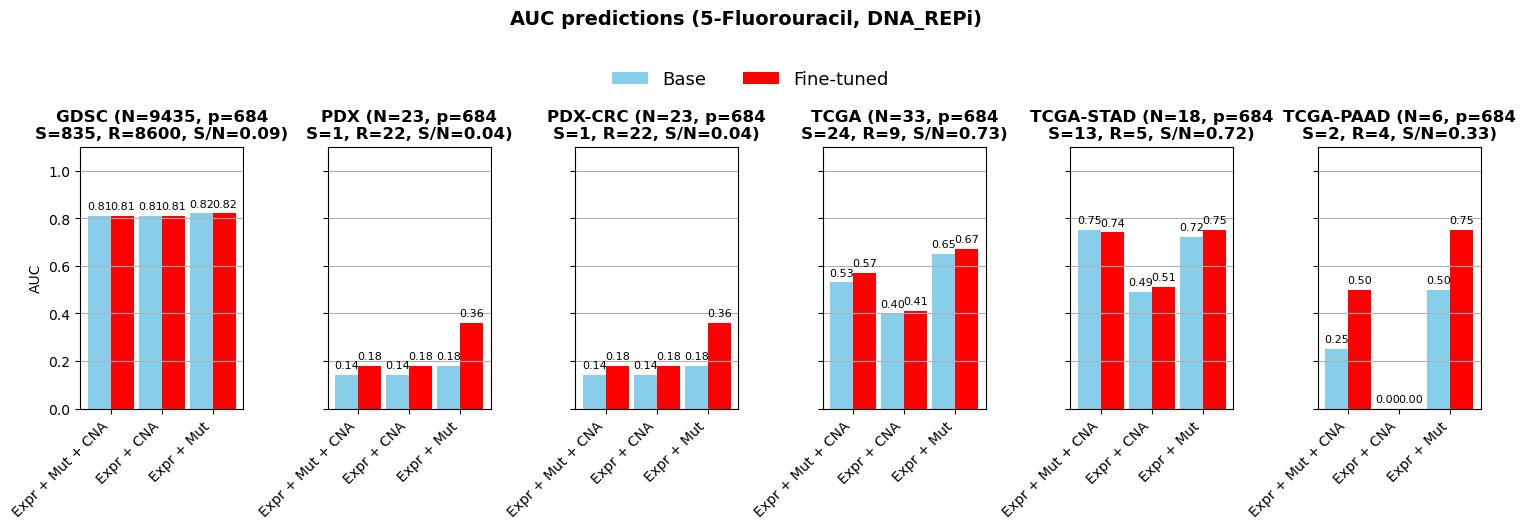

In [74]:
# plot AUC scores

df = auc_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.45
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

axes[0].set_ylabel('AUC')
fig.suptitle('AUC predictions (5-Fluorouracil, DNA_REPi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUC Plot (5-Fluorouracil, DNA_REPi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [75]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

aucpr_dataframe = all_dataframe[[f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUCPR (PDX, N={str(len(Ytsfluorouracil_pdx))})",
                               f"AUCPR (PDX-CRC, N={str(len(Ytsfluorouracil_pdx_crc))})",
                               f"AUCPR (TCGA, N={str(len(Ytsfluorouracil_tcga))})",
                               f"AUCPR (TCGA-PAAD, N={str(len(Ytsfluorouracil_tcga_paad))})"]]


aucpr_dataframe.rename(
    columns = {
        f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUCPR (PDX, N={str(len(Ytsfluorouracil_pdx))})": f"PDX (N={str(len(Ytsfluorouracil_pdx))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRfluorouracil["response"].value_counts()[1]) + ", R=" + str(PDXRfluorouracil["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRfluorouracil["response"].value_counts()[1]/sum(PDXRfluorouracil["response"].value_counts()), 2)) + ")",        
        f"AUCPR (PDX-CRC, N={str(len(Ytsfluorouracil_pdx_crc))})": f"PDX-CRC (N={str(len(Ytsfluorouracil_pdx_crc))}, p=" + str(PDXEfluorouracil.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()), 2)) + ")",        
        f"AUCPR (TCGA, N={str(len(Ytsfluorouracil_tcga))})": f"TCGA (N={str(len(Ytsfluorouracil_tcga))}, p=" + str(PDXEfluorouracil.shape[1]) + "\nS=" + str(TCGARfluorouracil["response"].value_counts()[1]) + ", R=" + str(TCGARfluorouracil["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARfluorouracil["response"].value_counts()[1]/sum(TCGARfluorouracil["response"].value_counts()), 2)) + ")",     
        f"AUCPR (TCGA-STAD, N={str(len(Ytsfluorouracil_tcga_stad))})": f"TCGA-STAD (N={str(len(Ytsfluorouracil_tcga_stad))}, p=" + str(TCGAEfluorouracil.shape[1]) + "\nS=" + str(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "STAD","response"].value_counts()[1]) + ", R=" + str(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "STAD","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "STAD","response"].value_counts()[1]/sum(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "STAD","response"].value_counts()), 2)) + ")",
        f"AUCPR (TCGA-PAAD, N={str(len(Ytsfluorouracil_tcga_paad))})": f"TCGA-PAAD (N={str(len(Ytsfluorouracil_tcga_paad))}, p=" + str(TCGAEfluorouracil.shape[1]) + "\nS=" + str(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD","response"].value_counts()[1]) + ", R=" + str(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD","response"].value_counts()[1]/sum(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
aucpr_dataframe

,"GDSC (N=9435, p=684\nS=835, R=8600, S/N=0.09)","PDX (N=23, p=684\nS=1, R=22, S/N=0.04)","PDX-CRC (N=23, p=684\nS=1, R=22, S/N=0.04)","TCGA (N=33, p=684\nS=24, R=9, S/N=0.73)","TCGA-PAAD (N=6, p=684\nS=2, R=4, S/N=0.33)"
Data,,,,,
Expr + Mut + CNA,0.34,0.05,0.05,0.74,0.32
Expr + Mut + CNA (Fine-tuned),0.34,0.05,0.05,0.78,0.45
Expr + CNA,0.33,0.05,0.05,0.75,0.27
Expr + CNA (Fine-tuned),0.33,0.05,0.05,0.75,0.27
Expr + Mut,0.33,0.05,0.05,0.82,0.45
Expr + Mut (Fine-tuned),0.33,0.07,0.07,0.85,0.75


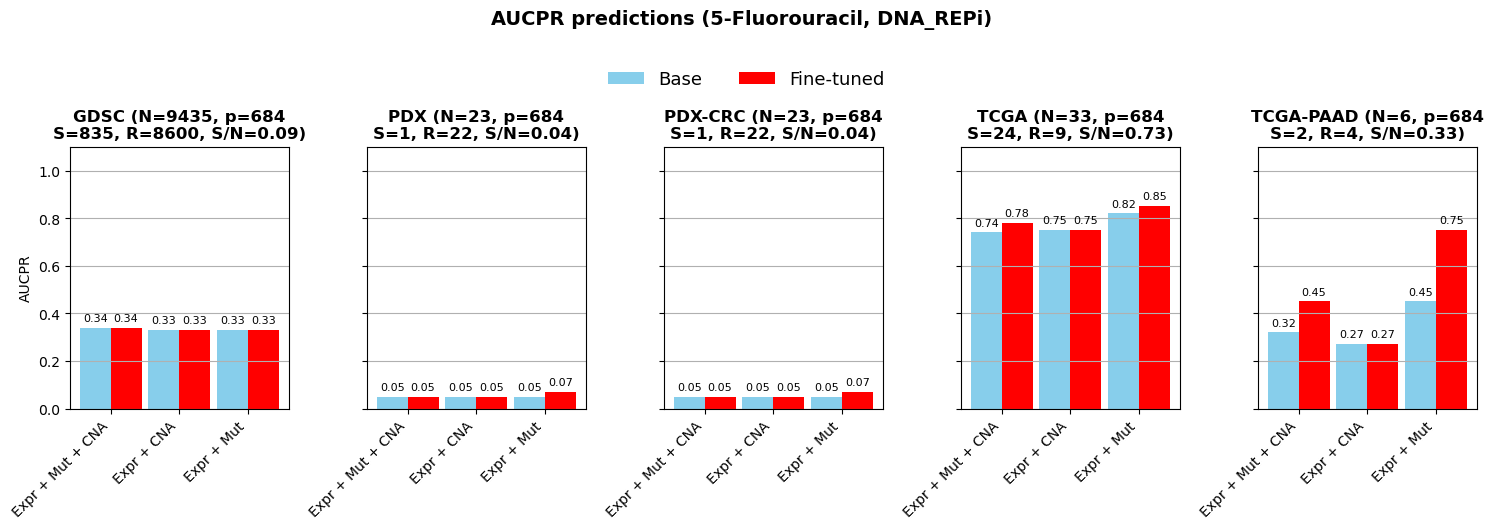

In [76]:
# plot AUCPR scores

df = aucpr_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.45
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

axes[0].set_ylabel('AUCPR')
fig.suptitle('AUCPR predictions (5-Fluorouracil, DNA_REPi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUCPR Plot (5-Fluorouracil, DNA_REPi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [77]:
# change directory

os.chdir(save_results_to)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/Predictions/GDSC_PDX_TCGA_Second_Strategy


In [78]:
# save predictions

file = open('GDSC_PDX_TCGA_DNA_REPi_Fluorouracil_Predictions_Second_Strategy (Expression and Mutation).txt', 'w')
file.write(f"GDSC Training (EM) AUC (DNA_REPi): {round(AUCT,2)}\n")
file.write(f"GDSC Training (EM) AUCPR (DNA_REPi): {round(AUCTaucpr,2)}\n\n")

file.write(f"PDX Test (EM) AUC (5-Fluorouracil): {round(AUCTfluorouracil_pdx,2)}\n")
file.write(f"PDX Test (EM) AUCPR (5-Fluorouracil): {round(AUCTfluorouracil_pdx_aucpr,2)}\n\n")

file.write(f"PDX Test (EM) AUC (5-Fluorouracil, CRC): {round(AUCTfluorouracil_pdx_crc,2)}\n")
file.write(f"PDX Test (EM) AUCPR (5-Fluorouracil, CRC): {round(AUCTfluorouracil_pdx_crc_aucpr,2)}\n\n")

file.write(f"TCGA Test (EM) AUC (5-Fluorouracil): {round(AUCTfluorouracil_tcga,2)}\n")
file.write(f"TCGA Test (EM) AUCPR (5-Fluorouracil): {round(AUCTfluorouracil_tcga_aucpr,2)}\n\n")

file.write(f"TCGA Test (EM) AUC (5-Fluorouracil, STAD): {round(AUCTfluorouracil_tcga_stad,2)}\n")
file.write(f"TCGA Test (EM) AUCPR (5-Fluorouracil, STAD): {round(AUCTfluorouracil_tcga_stad_aucpr,2)}\n")

file.write(f"TCGA Test (EM) AUC (5-Fluorouracil, PAAD): {round(AUCTfluorouracil_tcga_paad,2)}\n")
file.write(f"TCGA Test (EM) AUCPR (5-Fluorouracil, PAAD): {round(AUCTfluorouracil_tcga_paad_aucpr,2)}\n")

file.close()

In [79]:
# get Gene symbols from Entrez ID

gene_list = mg.querymany(GDSCEv2.columns, 
                         species="human", 
                         scopes = "entrezgene",
                         field = "symbol",
                         as_dataframe=True)["symbol"]
gene_list

query
118788    PIK3AP1
2059         EPS8
8204        NRIP1
79887       PLBD1
94234       FOXQ1
           ...   
51176        LEF1
10217      CTDSPL
51186      TCEAL9
4082       MARCKS
90102      PHLDB2
Name: symbol, Length: 684, dtype: object

In [80]:
# change directory to read DEG file (fluorouracil)

os.chdir(fluorouracil_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/DNA_REPi/5-Fluorouracil


In [81]:
# read DEG file (fluorouracil)

fluorouracil_DEGs_data = pd.read_excel("Limma Results (EnsemblID).xlsx")
fluorouracil_DEGs_data = fluorouracil_DEGs_data.set_index('ID', drop=True)
fluorouracil_DEGs_data.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B
ID,,,,,,
ENSG00000163154,-1.657175,3.714968,-12.835893,2.732888e-34,4.980143e-30,66.875275
ENSG00000086730,-2.029515,3.977429,-11.755351,1.920492e-29,1.749856e-25,55.939540
ENSG00000009790,-1.392800,3.472501,-11.507140,2.271334e-28,1.379684e-24,53.520003
ENSG00000142347,-1.205930,3.571808,-11.349699,1.068095e-27,4.865976e-24,52.004034
ENSG00000061676,2.460185,9.242849,11.193971,4.867039e-27,1.773841e-23,50.519116


In [82]:
# get Gene symbols from Ensembl gene IDs

gene_symbols = mg.querymany(fluorouracil_DEGs_data.index, 
                              species="human", 
                              scopes = "ensembl.gene",
                              field = "symbol",
                              as_dataframe=True)["symbol"]
gene_symbols

1 input query terms found dup hits:	[('ENSG00000226506', 2)]
15 input query terms found no hit:	['ENSG00000176659', 'ENSG00000277796', 'ENSG00000224287', 'ENSG00000230525', 'ENSG00000239332', 'ENS


query
ENSG00000163154    TNFAIP8L2
ENSG00000086730         LAT2
ENSG00000009790     TRAF3IP3
ENSG00000142347        MYO1F
ENSG00000061676       NCKAP1
                     ...    
ENSG00000166819        PLIN1
ENSG00000292053     KRTAP4-7
ENSG00000140403       DNAJA4
ENSG00000182400     TRAPPC6B
ENSG00000104044         OCA2
Name: symbol, Length: 18224, dtype: object

In [83]:
# merge Gene symbol column to the table

fluorouracil_merged_DEGs_data = pd.merge(fluorouracil_DEGs_data, pd.DataFrame(gene_symbols),  
                                       left_index=True, 
                                       right_index=True, 
                                       how='inner')

fluorouracil_merged_DEGs_data.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B,symbol
ID,,,,,,,
ENSG00000163154,-1.657175,3.714968,-12.835893,2.732888e-34,4.980143e-30,66.875275,TNFAIP8L2
ENSG00000086730,-2.029515,3.977429,-11.755351,1.920492e-29,1.749856e-25,55.939540,LAT2
ENSG00000009790,-1.392800,3.472501,-11.507140,2.271334e-28,1.379684e-24,53.520003,TRAF3IP3
ENSG00000142347,-1.205930,3.571808,-11.349699,1.068095e-27,4.865976e-24,52.004034,MYO1F
ENSG00000061676,2.460185,9.242849,11.193971,4.867039e-27,1.773841e-23,50.519116,NCKAP1


In [84]:
# subset DEGs in dataframe

filter = fluorouracil_merged_DEGs_data["symbol"].isin(gene_list)
fluorouracil_merged_DEGs_data = fluorouracil_merged_DEGs_data.loc[filter,:]

fluorouracil_merged_DEGs_data.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B,symbol
ID,,,,,,,
ENSG00000086730,-2.029515,3.977429,-11.755351,1.920492e-29,1.749856e-25,55.939540,LAT2
ENSG00000009790,-1.392800,3.472501,-11.507140,2.271334e-28,1.379684e-24,53.520003,TRAF3IP3
ENSG00000061676,2.460185,9.242849,11.193971,4.867039e-27,1.773841e-23,50.519116,NCKAP1
ENSG00000136286,-1.332721,3.455223,-11.147245,7.649736e-27,2.323352e-23,50.076424,MYO1G
ENSG00000105122,-1.625836,3.863206,-11.108948,1.107064e-26,2.882005e-23,49.714574,RASAL3


In [85]:
# export table for pathfindR analysis

os.makedirs(pathfindR_dir, exist_ok = True)

fluorouracil_merged_DEGs_data.to_csv(pathfindR_dir + "GDSC_Expression_Mutation_Filtered_DEGs_Table_DNA_REPi_Fluorouracil.tsv",
                                   index = False,
                                   sep = "\t")

In [86]:
# change directory to read GDSC response dataset (DNA_REPi)

os.chdir(dataset_dir + "/response/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response


In [87]:
# read GDSC response dataset (DNA_REPi)

GDSCR = pd.read_csv("GDSC_response.DNA_REPi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCR.dropna(inplace=True)
GDSCR.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
GDSCR["response"] = GDSCR.loc[:, "response"].apply(lambda x: d[x])

GDSCR.head()

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,0,5.12075503641523,Pyrimethamine,1,1,1
683665,0,-3.03711635474651,Doxorubicin,1,1,1
683665,0,-0.712119156515401,Etoposide,1,1,1
683665,0,-4.40897202584936,Gemcitabine,1,1,1
683665,0,-1.59752443691324,Mitomycin C,1,1,1


In [88]:
# GDSC response data

responses = GDSCR
responses.head(3)

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,0,5.12075503641523,Pyrimethamine,1,1,1
683665,0,-3.03711635474651,Doxorubicin,1,1,1
683665,0,-0.712119156515401,Etoposide,1,1,1


In [89]:
# convert Entrez gene ID to string

responses.index = responses.index.astype(str)
responses.index

Index(['683665', '683665', '683665', '683665', '683665', '683665', '683665',
       '683665', '683665', '683665',
       ...
       '1659818', '1659818', '1659818', '1659818', '1659819', '1659819',
       '1659819', '1659819', '1659819', '687800'],
      dtype='object', name='sample_name', length=9435)

In [90]:
# filter expression abd mutation datasets as to drugs
# filter selected DEGs

expression_zscores = []
mutations = []
for drug in drugs:
    samples = responses.loc[responses["drug"] == drug, :].index.values
    e_z = exprs_z.loc[samples, :]
    m = mut.loc[samples, :]
    expression_zscores.append(e_z)
    mutations.append(m)

GDSCEv2 = pd.concat(expression_zscores, axis=0)
GDSCMv2 = pd.concat(mutations, axis=0)
GDSCRv2 = responses

ls5 = list(set(GDSCE.columns).intersection(set(DEGs_entrez_id.astype(int))))
ls6 = GDSCEv2.index.intersection(GDSCMv2.index)

GDSCEv2 = GDSCEv2.loc[ls6, ls5]
GDSCMv2 = GDSCMv2.loc[ls6, ls5]
GDSCRv2 = GDSCRv2.loc[ls6, :]

PDXEfluorouracil = PDXEfluorouracil.loc[:,ls5]
PDXMfluorouracil = PDXMfluorouracil.loc[:,ls5]
TCGAEfluorouracil = TCGAEfluorouracil.loc[:,ls5]
TCGAMfluorouracil = TCGAMfluorouracil.loc[:,ls5]

responses.index = responses.index.values + "_" + responses["drug"].values

print(f"GDSC # of common samples and genes (Expression): {GDSCEv2.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCMv2.shape}")
print(f"GDSC # of common samples (Response): {GDSCRv2.shape[0]}\n")

print(f"PDX # of common samples and genes for 5-Fluorouracil (Expression): {PDXEfluorouracil.shape}")
print(f"PDX # of common samples and genes for 5-Fluorouracil (Mutation): {PDXMfluorouracil.shape}\n")

print(f"TCGA # of common samples and genes for 5-Fluorouracil (Expression): {TCGAEfluorouracil.shape}")
print(f"TCGA # of common samples and genes for 5-Fluorouracil (Mutation): {TCGAMfluorouracil.shape}")

GDSC # of common samples and genes (Expression): (9435, 684)
GDSC # of common samples and genes (Mutation): (9435, 684)
GDSC # of common samples (Response): 9435

PDX # of common samples and genes for 5-Fluorouracil (Expression): (23, 684)
PDX # of common samples and genes for 5-Fluorouracil (Mutation): (23, 684)

TCGA # of common samples and genes for 5-Fluorouracil (Expression): (33, 684)
TCGA # of common samples and genes for 5-Fluorouracil (Mutation): (33, 684)


In [91]:
# subset sensitive and resistant cell lines in GDSC and PDX 

filter = (GDSCRv2["drug"] == "5-Fluorouracil")
fluorouracil_samples = GDSCRv2.loc[filter,:]

filter = (fluorouracil_samples["response"] == 0)
gdsc_fluorouracil_resistant_samples = fluorouracil_samples.loc[filter,:].index
gdsc_fluorouracil_sensitive_samples = fluorouracil_samples.loc[~filter,:].index

filter = (PDXRfluorouracil["response"] == 0)
pdx_fluorouracil_resistant_samples = PDXRfluorouracil.loc[filter,:].index
pdx_fluorouracil_sensitive_samples = PDXRfluorouracil.loc[~filter,:].index

filter = (TCGARfluorouracil["response"] == 0)
tcga_fluorouracil_resistant_samples = TCGARfluorouracil.loc[filter,:].index
tcga_fluorouracil_sensitive_samples = TCGARfluorouracil.loc[~filter,:].index

print(f"There are {gdsc_fluorouracil_sensitive_samples.shape[0]} 5-Fluorouracil sensitive cell lines in GDSC")
print(f"There are {gdsc_fluorouracil_resistant_samples.shape[0]} 5-Fluorouracil resistant cell lines in GDSC\n")

print(f"There are {pdx_fluorouracil_sensitive_samples.shape[0]} 5-Fluorouracil sensitive cell lines in PDX")
print(f"There are {pdx_fluorouracil_resistant_samples.shape[0]} 5-Fluorouracil resistant cell lines in PDX\n")

print(f"There are {tcga_fluorouracil_sensitive_samples.shape[0]} 5-Fluorouracil sensitive cell lines in TCGA")
print(f"There are {tcga_fluorouracil_resistant_samples.shape[0]} 5-Fluorouracil resistant cell lines in TCGA")

There are 82 5-Fluorouracil sensitive cell lines in GDSC
There are 682 5-Fluorouracil resistant cell lines in GDSC

There are 1 5-Fluorouracil sensitive cell lines in PDX
There are 22 5-Fluorouracil resistant cell lines in PDX

There are 24 5-Fluorouracil sensitive cell lines in TCGA
There are 9 5-Fluorouracil resistant cell lines in TCGA


In [92]:
fluorouracil_samples.head(3)

,response,logIC50,drug,exprs,CNA,mutations
683665,1,0.145949081618724,5-Fluorouracil,1,1,1
684057,0,1.93715994302197,5-Fluorouracil,1,1,1
684059,1,0.615320491035313,5-Fluorouracil,1,1,1


In [93]:
PDXRfluorouracil.head(3)

,drug,response,ResponseCategory,Treatment,Treatment target,Treatment type,BestResponse,Day_BestResponse,BestAvgResponse,Day_BestAvgResponse,TimeToDouble,Day_Last,exprs,CNA,mutations
sample_name,,,,,,,,,,,,,,,
X-1027,5-Fluorouracil,0,PD,5FU,chemotherapy,single,640.3,20,184.22,13,4.918580375782881,20,1,1,1
X-1119,5-Fluorouracil,1,PR,5FU,chemotherapy,single,-56.8,71,-28.81153846153846,90,90.0,90,1,1,1
X-1173,5-Fluorouracil,0,SD,5FU,chemotherapy,single,-36.9,71,-4.938461538461539,90,90.0,90,1,1,1


In [94]:
TCGARfluorouracil.head(3)

,cohort,drug,response,measure_of_response,exprs_sample_barcode,cna_sample_barcode,mut_sample_barcode,patient
TCGA-3A-A9IC,PAAD,Fluorouracil,0,Stable Disease,TCGA-3A-A9IC-01A-11R-A38C-07,TCGA-3A-A9IC-01A-11D-A38F-01,TCGA-3A-A9IC-01A-11D-A38G-08,TCGA-3A-A9IC
TCGA-3A-A9IX,PAAD,Fluorouracil,1,Complete Response,TCGA-3A-A9IX-01A-11R-A41B-07,TCGA-3A-A9IX-01A-11D-A40V-01,TCGA-3A-A9IX-01A-11D-A40W-08,TCGA-3A-A9IX
TCGA-AG-3593,READ,Fluorouracil,1,Complete Response,TCGA-AG-3593-01A-01R-0821-07,TCGA-AG-3593-01A-01D-0819-01,TCGA-AG-3593-01A-01W-0831-10,TCGA-AG-3593


In [95]:
# export sensitive and resistant cell lines in GDSC for pathfindR analysis

gdsc_df = pd.DataFrame(fluorouracil_samples["response"])
gdsc_df = gdsc_df.reset_index()
gdsc_df.rename(columns = {"index": "Sample", "response": "Response"}, inplace = True)

gdsc_df.to_csv(pathfindR_dir + "GDSC_DNA_REPi_Fluorouracil_Samples_Second_Strategy.tsv",
               index = False,
               sep = "\t")

In [96]:
gdsc_df.head(3)

,Sample,Response
0,683665,1
1,684057,0
2,684059,1


In [97]:
# create and export experiment matrices for GDSC, PDX and TCGA for pathfindR analysis

filter = (GDSCE.index.isin(fluorouracil_samples.index))
gdsc_fluorouracil_df = GDSCE.loc[filter,:].transpose()

filter = (gdsc_fluorouracil_df.index.isin(GDSCEv2.columns))
gdsc_fluorouracil_exp_df = gdsc_fluorouracil_df.loc[filter,:]

gdsc_fluorouracil_exp_df.index = mg.querymany(gdsc_fluorouracil_exp_df.index,
                                            species="human",
                                            scopes = "entrezgene",
                                            field = "symbol",
                                            as_dataframe=True)["symbol"]

gdsc_fluorouracil_exp_df.to_csv(pathfindR_dir + "GDSC_Experiment_Matrix_DNA_REPi_Fluorouracil_Second_Strategy.tsv",
                              sep = "\t")

In [98]:
# change directory to read DEG file (fluorouracil)

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/DNA_REPi


In [99]:
# read DEG file (fluorouracil)

fluorouracil_DEGs_filtered_data = pd.read_excel("DNA_REPi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                              sheet_name = "5-Fluorouracil")
fluorouracil_DEGs_filtered_data = fluorouracil_DEGs_filtered_data.loc[:,["Gene.Symbol","logFC","adj.P.Val"]]

fluorouracil_DEGs_filtered_data.head()

,Gene.Symbol,logFC,adj.P.Val
0,TNFAIP8L2,-1.657175,4.980143e-30
1,LAT2,-2.029515,1.749856e-25
2,TRAF3IP3,-1.392800,1.379684e-24
3,MYO1F,-1.205930,4.865976e-24
4,NCKAP1,2.460185,1.773841e-23


In [100]:
# export frequency table of DEGs (fluorouracil)
# these genes are unionized DEGs including ones found for 5-Fluorouracil. 
# Frequency = 1 indicates that these genes are fluorouracil-unique DEGs among unionized DEGs found for DNA replication inhibitors

filter = DEGs_filtered_data["Gene Symbol"].isin(fluorouracil_DEGs_filtered_data["Gene.Symbol"])
DEGs_filtered_data.loc[filter,:].to_csv(pathfindR_dir + "GDSC_Expression_Mutation_DEGs_Freq_Table_Fluorouracil.tsv",
                                        index = False,
                                        sep = "\t")

In [101]:
DEGs_filtered_data.loc[filter,:]

,Gene Symbol,Frequency
0,SLFN11,9
1,NCKAP1L,8
2,SDC4,7
3,KRT18,7
4,S100A14,7
...,...,...
540,CYSLTR1,2
541,LAMB2,2
542,TNFAIP8L2,2
543,MARCKS,2


In [102]:
# export frequency table of DEGs (DNA_REPi)
# these genes are unionized DEGs for all DNA replication inhibitors

filter = DEGs_filtered_data["Gene Symbol"].isin(gene_list)
DEGs_filtered_data.loc[filter,:].to_csv(pathfindR_dir + "GDSC_PDX_TCGA_Expression_Mutation_DEGs_Freq_Table_DNA_REPi_Second_Strategy.tsv",
                                        index = False,
                                        sep = "\t")

In [103]:
DEGs_filtered_data.loc[filter,:]

,Gene Symbol,Frequency
0,SLFN11,9
2,SDC4,7
3,KRT18,7
4,S100A14,7
5,KRT19,7
...,...,...
853,IQGAP2,1
854,WWC2,1
855,HMGN5,1
856,FLNC,1
